# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

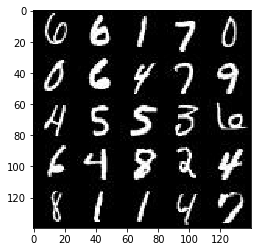

In [2]:
show_n_images = 25
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

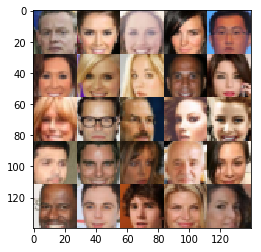

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32,name='learning_rate')
    return real_input,z_input,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [6]:
def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #input size : 28*28*3
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        conv1 = tf.layers.conv2d(inputs=images,filters=64,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        #bn1 = tf.layers.batch_normalization(inputs=conv1,training=True,epsilon=1e-5,momentum=0.9)
        lrelu1 = lrelu(conv1,alpha) #14*14*64
        
        conv2 = tf.layers.conv2d(inputs=lrelu1,filters=128,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())#tf.random_normal_initializer(mean=0.0, stddev=0.02)) 
        bn2 = tf.layers.batch_normalization(inputs=conv2,training=True,epsilon=1e-5,momentum=0.9)
        lrelu2 = lrelu(bn2,alpha) #7*7*128
        
        conv3 = tf.layers.conv2d(inputs=lrelu2,filters=256,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())#tf.random_normal_initializer(mean=0.0, stddev=0.02)) 
        bn3 = tf.layers.batch_normalization(inputs=conv3,training=True,epsilon=1e-5,momentum=0.9)
        lrelu3 = lrelu(bn3,alpha)#4*4*256
        
        flatten = tf.reshape(lrelu3,shape=(-1,4*4*256))
        logits = tf.layers.dense(inputs=flatten,units=1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())#tf.random_normal_initializer(mean=0.0, stddev=0.02))
        outputs = tf.sigmoid(logits)
        
    #output size : None,1
    return outputs,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=reuse):
        fc1 = tf.layers.dense(inputs=z,units=7*7*512)
        fc1 = tf.reshape(fc1,(-1,7,7,512))
        fc1 = tf.layers.batch_normalization(inputs=fc1,training=is_train,epsilon=1e-5,momentum=0.9)
        fc1 = lrelu(fc1,alpha)  #7*7*512
        
        tconv1 = tf.layers.conv2d_transpose(inputs=fc1,filters=256,strides=1,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        bn1 = tf.layers.batch_normalization(inputs=tconv1,training=is_train,epsilon=1e-5,momentum=0.9)
        lrelu1 = lrelu(bn1,alpha) #7*7*256
        
        tconv2 = tf.layers.conv2d_transpose(inputs=fc1,filters=128,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        bn2 = tf.layers.batch_normalization(inputs=tconv2,training=is_train,epsilon=1e-5,momentum=0.9)
        lrelu2 = lrelu(bn2,alpha) #14*14*128
        
        logits = tf.layers.conv2d_transpose(inputs=lrelu2,filters=out_channel_dim,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        outputs = tf.tanh(logits) #28*28*3
        
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smoothness = 0.1
    
    g_model = generator(z=input_z,out_channel_dim=out_channel_dim,is_train=True)
    d_real_outputs,d_real_logits = discriminator(images=input_real,reuse=False)
    d_fake_outputs,d_fake_logits = discriminator(images=g_model,reuse=True)
    
    #d_loss_real : 
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,labels=tf.ones_like(d_real_logits)*(1-label_smoothness)))
    
    #d_loss_fake :
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_logits)))
    
    #g_loss : 
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_logits)))
    
    dloss = d_loss_real + d_loss_fake
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get weights and bias of the networks separately
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    '''
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    '''
    #here batch normalization is the operation
    # Because the batch norm layers are not part of the graph we inforce these operation to run before the 
    # optimizers so the batch normalization layers can update their population statistics.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_op = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_op = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)

    return d_op,g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    real_input,z_input,lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(real_input, z_input, image_channels)
    op_d,op_g = model_opt(d_loss, g_loss, lr, beta1)
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(low=-1,high=1,size=(batch_size,z_dim))
                
                #training discriminator network first
                _ = sess.run(op_d,feed_dict={real_input:batch_images,
                                                     z_input:batch_z,
                                                     lr: learning_rate
                                                     })
                
                #training generator network
                _ = sess.run(op_g,feed_dict={real_input:batch_images,
                                                     z_input:batch_z,
                                                     lr: learning_rate
                                                     })
                
                #show generator output
                if steps%100==0:
                    show_generator_output(sess,16,z_input,image_channels,data_image_mode)
                
                if steps%10==0:
                    dloss_train = sess.run(d_loss,feed_dict={real_input:batch_images,z_input:batch_z})
                    gloss_train = sess.run(g_loss,feed_dict={z_input:batch_z})
                    print("Epoch:{}, Step:{}, Discriminator Loss:{}, Generator Loss:{}".format(epoch_i+1,steps,dloss_train,gloss_train))                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:1, Step:10, Discriminator Loss:3.5682425498962402, Generator Loss:0.1965634524822235
Epoch:1, Step:20, Discriminator Loss:1.40535569190979, Generator Loss:0.8590847253799438
Epoch:1, Step:30, Discriminator Loss:0.5595524907112122, Generator Loss:4.407740592956543
Epoch:1, Step:40, Discriminator Loss:0.8970261812210083, Generator Loss:1.6469783782958984
Epoch:1, Step:50, Discriminator Loss:0.9876461029052734, Generator Loss:1.1423810720443726
Epoch:1, Step:60, Discriminator Loss:1.1616214513778687, Generator Loss:0.8191381692886353
Epoch:1, Step:70, Discriminator Loss:1.755881428718567, Generator Loss:0.33334964513778687
Epoch:1, Step:80, Discriminator Loss:1.090996503829956, Generator Loss:0.8168182373046875
Epoch:1, Step:90, Discriminator Loss:1.75697922706604, Generator Loss:0.33620715141296387


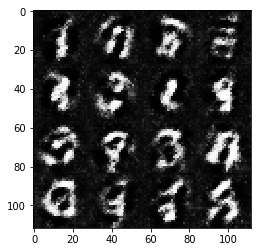

Epoch:1, Step:100, Discriminator Loss:1.3378431797027588, Generator Loss:0.587308406829834
Epoch:1, Step:110, Discriminator Loss:0.9618109464645386, Generator Loss:1.0861680507659912
Epoch:1, Step:120, Discriminator Loss:1.0238720178604126, Generator Loss:1.2084062099456787
Epoch:1, Step:130, Discriminator Loss:0.9522552490234375, Generator Loss:1.0708913803100586
Epoch:1, Step:140, Discriminator Loss:1.246111512184143, Generator Loss:0.6165392398834229
Epoch:1, Step:150, Discriminator Loss:1.085789680480957, Generator Loss:0.7238919138908386
Epoch:1, Step:160, Discriminator Loss:1.2348415851593018, Generator Loss:0.6303562521934509
Epoch:1, Step:170, Discriminator Loss:1.133789300918579, Generator Loss:2.419947624206543
Epoch:1, Step:180, Discriminator Loss:0.8301352262496948, Generator Loss:1.6332545280456543
Epoch:1, Step:190, Discriminator Loss:0.8906152844429016, Generator Loss:1.018178939819336


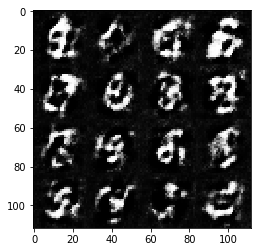

Epoch:1, Step:200, Discriminator Loss:0.8906768560409546, Generator Loss:1.3155384063720703
Epoch:1, Step:210, Discriminator Loss:0.9822294116020203, Generator Loss:2.7470574378967285
Epoch:1, Step:220, Discriminator Loss:0.8309677839279175, Generator Loss:1.7301130294799805
Epoch:1, Step:230, Discriminator Loss:0.7572564482688904, Generator Loss:1.5441005229949951
Epoch:1, Step:240, Discriminator Loss:0.701332688331604, Generator Loss:1.9831510782241821
Epoch:1, Step:250, Discriminator Loss:0.8904451131820679, Generator Loss:0.9562062621116638
Epoch:1, Step:260, Discriminator Loss:1.1979269981384277, Generator Loss:3.0195298194885254
Epoch:1, Step:270, Discriminator Loss:0.7056319117546082, Generator Loss:1.4928237199783325
Epoch:1, Step:280, Discriminator Loss:0.7280285358428955, Generator Loss:2.1461691856384277
Epoch:1, Step:290, Discriminator Loss:0.9503818154335022, Generator Loss:1.0233116149902344


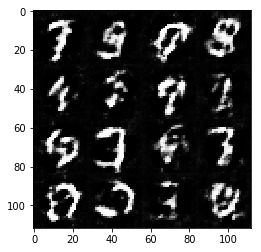

Epoch:1, Step:300, Discriminator Loss:0.6998018026351929, Generator Loss:2.1224396228790283
Epoch:1, Step:310, Discriminator Loss:0.8525203466415405, Generator Loss:1.123661756515503
Epoch:1, Step:320, Discriminator Loss:0.7445952892303467, Generator Loss:1.5138368606567383
Epoch:1, Step:330, Discriminator Loss:0.9525748491287231, Generator Loss:0.9183764457702637
Epoch:1, Step:340, Discriminator Loss:1.0603346824645996, Generator Loss:0.8574163913726807
Epoch:1, Step:350, Discriminator Loss:0.7779498100280762, Generator Loss:1.351168155670166
Epoch:1, Step:360, Discriminator Loss:0.9860230684280396, Generator Loss:2.1879189014434814
Epoch:1, Step:370, Discriminator Loss:0.8814488649368286, Generator Loss:1.1262309551239014
Epoch:1, Step:380, Discriminator Loss:1.772072434425354, Generator Loss:0.39473390579223633
Epoch:1, Step:390, Discriminator Loss:0.8745891451835632, Generator Loss:2.276949882507324


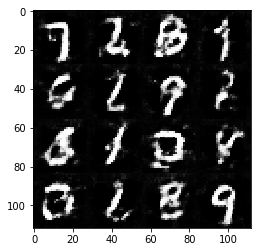

Epoch:1, Step:400, Discriminator Loss:0.8680609464645386, Generator Loss:1.0633043050765991
Epoch:1, Step:410, Discriminator Loss:1.1546227931976318, Generator Loss:0.8399310111999512
Epoch:1, Step:420, Discriminator Loss:0.9999657869338989, Generator Loss:0.8842403292655945
Epoch:1, Step:430, Discriminator Loss:1.6569478511810303, Generator Loss:4.078790664672852
Epoch:1, Step:440, Discriminator Loss:1.0945889949798584, Generator Loss:0.729905366897583
Epoch:1, Step:450, Discriminator Loss:1.096834659576416, Generator Loss:0.8064377307891846
Epoch:1, Step:460, Discriminator Loss:0.7605003714561462, Generator Loss:1.6975407600402832
Epoch:1, Step:470, Discriminator Loss:0.8951152563095093, Generator Loss:2.2911453247070312
Epoch:1, Step:480, Discriminator Loss:1.3792036771774292, Generator Loss:0.57640141248703
Epoch:1, Step:490, Discriminator Loss:0.8456805944442749, Generator Loss:2.2172017097473145


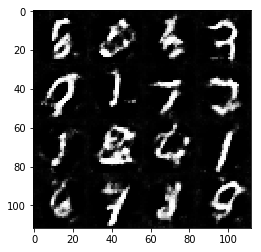

Epoch:1, Step:500, Discriminator Loss:0.9021977186203003, Generator Loss:0.9889209270477295
Epoch:1, Step:510, Discriminator Loss:0.6714954376220703, Generator Loss:1.8865503072738647
Epoch:1, Step:520, Discriminator Loss:1.0176773071289062, Generator Loss:0.8412928581237793
Epoch:1, Step:530, Discriminator Loss:1.0394994020462036, Generator Loss:0.840743362903595
Epoch:1, Step:540, Discriminator Loss:0.8323333263397217, Generator Loss:1.1444300413131714
Epoch:1, Step:550, Discriminator Loss:0.9444386959075928, Generator Loss:2.469266653060913
Epoch:1, Step:560, Discriminator Loss:0.8796602487564087, Generator Loss:1.0347278118133545
Epoch:1, Step:570, Discriminator Loss:0.8974050283432007, Generator Loss:2.6826794147491455
Epoch:1, Step:580, Discriminator Loss:1.1268783807754517, Generator Loss:0.7092146873474121
Epoch:1, Step:590, Discriminator Loss:0.9400655031204224, Generator Loss:0.9732590913772583


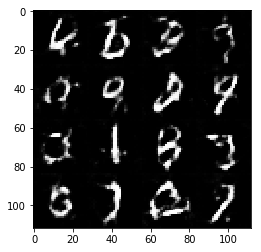

Epoch:1, Step:600, Discriminator Loss:0.8108119964599609, Generator Loss:1.6737655401229858
Epoch:1, Step:610, Discriminator Loss:0.9368109107017517, Generator Loss:1.8333059549331665
Epoch:1, Step:620, Discriminator Loss:0.8081961870193481, Generator Loss:1.3501150608062744
Epoch:1, Step:630, Discriminator Loss:0.7637350559234619, Generator Loss:1.326004981994629
Epoch:1, Step:640, Discriminator Loss:0.9532088041305542, Generator Loss:0.9975765943527222
Epoch:1, Step:650, Discriminator Loss:1.9749952554702759, Generator Loss:0.33177125453948975
Epoch:1, Step:660, Discriminator Loss:0.7450360059738159, Generator Loss:1.535743236541748
Epoch:1, Step:670, Discriminator Loss:1.0363682508468628, Generator Loss:0.8298614025115967
Epoch:1, Step:680, Discriminator Loss:1.1032013893127441, Generator Loss:0.8015947341918945
Epoch:1, Step:690, Discriminator Loss:1.1383123397827148, Generator Loss:0.7625734806060791


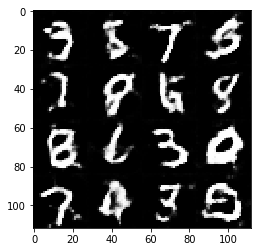

Epoch:1, Step:700, Discriminator Loss:1.5773117542266846, Generator Loss:0.43899762630462646
Epoch:1, Step:710, Discriminator Loss:0.9462196826934814, Generator Loss:1.0870188474655151
Epoch:1, Step:720, Discriminator Loss:0.8932645320892334, Generator Loss:1.9360140562057495
Epoch:1, Step:730, Discriminator Loss:0.817957878112793, Generator Loss:1.6576168537139893
Epoch:1, Step:740, Discriminator Loss:0.6690258979797363, Generator Loss:1.8645036220550537
Epoch:1, Step:750, Discriminator Loss:0.6884270906448364, Generator Loss:1.8099195957183838
Epoch:1, Step:760, Discriminator Loss:0.6319757699966431, Generator Loss:1.8884899616241455
Epoch:1, Step:770, Discriminator Loss:0.9657094478607178, Generator Loss:1.0074182748794556
Epoch:1, Step:780, Discriminator Loss:0.8709039092063904, Generator Loss:1.0213110446929932
Epoch:1, Step:790, Discriminator Loss:0.818320631980896, Generator Loss:1.4285153150558472


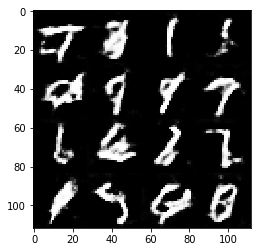

Epoch:1, Step:800, Discriminator Loss:0.8105976581573486, Generator Loss:1.1302297115325928
Epoch:1, Step:810, Discriminator Loss:1.2450730800628662, Generator Loss:0.6129440665245056
Epoch:1, Step:820, Discriminator Loss:0.8542606830596924, Generator Loss:1.6042776107788086
Epoch:1, Step:830, Discriminator Loss:0.6279221773147583, Generator Loss:1.8781774044036865
Epoch:1, Step:840, Discriminator Loss:0.9586687088012695, Generator Loss:0.8700745105743408
Epoch:1, Step:850, Discriminator Loss:0.6600090265274048, Generator Loss:1.6066923141479492
Epoch:1, Step:860, Discriminator Loss:0.7872380018234253, Generator Loss:1.3635998964309692
Epoch:1, Step:870, Discriminator Loss:0.6635634899139404, Generator Loss:1.6179451942443848
Epoch:1, Step:880, Discriminator Loss:0.6478662490844727, Generator Loss:1.5942281484603882
Epoch:1, Step:890, Discriminator Loss:0.8366674184799194, Generator Loss:1.092439889907837


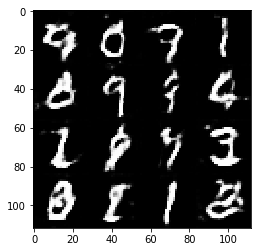

Epoch:1, Step:900, Discriminator Loss:0.7025165557861328, Generator Loss:1.615574598312378
Epoch:1, Step:910, Discriminator Loss:1.7545801401138306, Generator Loss:0.3256065249443054
Epoch:1, Step:920, Discriminator Loss:0.9504768252372742, Generator Loss:1.217078447341919
Epoch:1, Step:930, Discriminator Loss:1.2315646409988403, Generator Loss:0.6235635280609131
Epoch:2, Step:940, Discriminator Loss:0.8148738145828247, Generator Loss:1.673017978668213
Epoch:2, Step:950, Discriminator Loss:0.9222612380981445, Generator Loss:1.509529948234558
Epoch:2, Step:960, Discriminator Loss:1.1473090648651123, Generator Loss:0.7450061440467834
Epoch:2, Step:970, Discriminator Loss:0.7935982942581177, Generator Loss:1.127447485923767
Epoch:2, Step:980, Discriminator Loss:1.0399622917175293, Generator Loss:0.9696599245071411
Epoch:2, Step:990, Discriminator Loss:0.8043670654296875, Generator Loss:1.2446579933166504


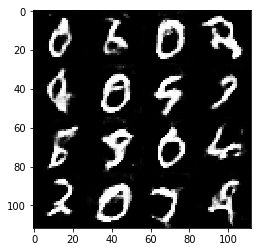

Epoch:2, Step:1000, Discriminator Loss:0.7099774479866028, Generator Loss:1.638054370880127
Epoch:2, Step:1010, Discriminator Loss:0.7687910795211792, Generator Loss:1.2560429573059082
Epoch:2, Step:1020, Discriminator Loss:0.7177010774612427, Generator Loss:1.3356080055236816
Epoch:2, Step:1030, Discriminator Loss:0.7852439284324646, Generator Loss:1.1747242212295532
Epoch:2, Step:1040, Discriminator Loss:1.636321783065796, Generator Loss:0.4391861855983734
Epoch:2, Step:1050, Discriminator Loss:0.6792129278182983, Generator Loss:1.6537079811096191
Epoch:2, Step:1060, Discriminator Loss:0.6949564218521118, Generator Loss:1.6351197957992554
Epoch:2, Step:1070, Discriminator Loss:0.8109492063522339, Generator Loss:1.1258896589279175
Epoch:2, Step:1080, Discriminator Loss:0.7476358413696289, Generator Loss:1.3515162467956543
Epoch:2, Step:1090, Discriminator Loss:1.0224528312683105, Generator Loss:0.9111220836639404


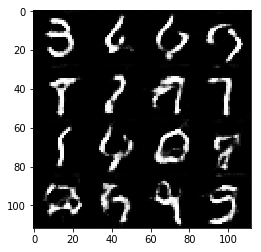

Epoch:2, Step:1100, Discriminator Loss:0.9848665595054626, Generator Loss:0.9576441049575806
Epoch:2, Step:1110, Discriminator Loss:0.653610110282898, Generator Loss:1.66745924949646
Epoch:2, Step:1120, Discriminator Loss:0.7859548330307007, Generator Loss:1.165360927581787
Epoch:2, Step:1130, Discriminator Loss:0.7368514537811279, Generator Loss:1.4450674057006836
Epoch:2, Step:1140, Discriminator Loss:0.7377339601516724, Generator Loss:1.5183641910552979
Epoch:2, Step:1150, Discriminator Loss:0.7272738814353943, Generator Loss:1.379312515258789
Epoch:2, Step:1160, Discriminator Loss:0.9871361255645752, Generator Loss:0.9647494554519653
Epoch:2, Step:1170, Discriminator Loss:1.0503665208816528, Generator Loss:0.8262107372283936
Epoch:2, Step:1180, Discriminator Loss:1.2751809358596802, Generator Loss:0.644749104976654
Epoch:2, Step:1190, Discriminator Loss:1.66713547706604, Generator Loss:0.406127005815506


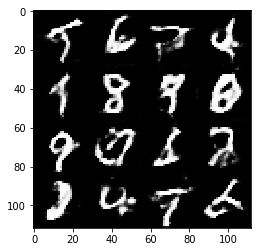

Epoch:2, Step:1200, Discriminator Loss:0.7169629335403442, Generator Loss:1.3415632247924805
Epoch:2, Step:1210, Discriminator Loss:0.6559012532234192, Generator Loss:1.6289384365081787
Epoch:2, Step:1220, Discriminator Loss:2.6485495567321777, Generator Loss:5.24573278427124
Epoch:2, Step:1230, Discriminator Loss:0.7557151317596436, Generator Loss:1.4036707878112793
Epoch:2, Step:1240, Discriminator Loss:1.0985623598098755, Generator Loss:0.7660865783691406
Epoch:2, Step:1250, Discriminator Loss:0.7856884002685547, Generator Loss:1.2193602323532104
Epoch:2, Step:1260, Discriminator Loss:1.3615593910217285, Generator Loss:0.575081467628479
Epoch:2, Step:1270, Discriminator Loss:1.0108367204666138, Generator Loss:0.8552952408790588
Epoch:2, Step:1280, Discriminator Loss:0.8201943039894104, Generator Loss:1.341317057609558
Epoch:2, Step:1290, Discriminator Loss:0.7303789258003235, Generator Loss:1.3424441814422607


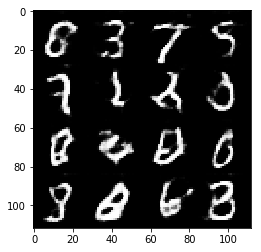

Epoch:2, Step:1300, Discriminator Loss:0.8500880002975464, Generator Loss:1.0549720525741577
Epoch:2, Step:1310, Discriminator Loss:1.223927617073059, Generator Loss:0.6780054569244385
Epoch:2, Step:1320, Discriminator Loss:0.9056568145751953, Generator Loss:0.9904844164848328
Epoch:2, Step:1330, Discriminator Loss:0.6755450367927551, Generator Loss:1.490338683128357
Epoch:2, Step:1340, Discriminator Loss:0.772857129573822, Generator Loss:1.250178337097168
Epoch:2, Step:1350, Discriminator Loss:0.8962454795837402, Generator Loss:1.0215013027191162
Epoch:2, Step:1360, Discriminator Loss:1.0259138345718384, Generator Loss:0.8692687749862671
Epoch:2, Step:1370, Discriminator Loss:0.9989092350006104, Generator Loss:0.8789384365081787
Epoch:2, Step:1380, Discriminator Loss:0.9368950128555298, Generator Loss:0.9923847913742065
Epoch:2, Step:1390, Discriminator Loss:0.9391981363296509, Generator Loss:2.471959114074707


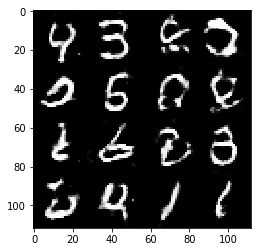

Epoch:2, Step:1400, Discriminator Loss:0.8830543160438538, Generator Loss:1.359210729598999
Epoch:2, Step:1410, Discriminator Loss:0.6961075067520142, Generator Loss:1.8901994228363037
Epoch:2, Step:1420, Discriminator Loss:0.8408250212669373, Generator Loss:1.0483193397521973
Epoch:2, Step:1430, Discriminator Loss:0.7093881368637085, Generator Loss:1.9602196216583252
Epoch:2, Step:1440, Discriminator Loss:1.211687684059143, Generator Loss:0.6376286745071411
Epoch:2, Step:1450, Discriminator Loss:1.3875353336334229, Generator Loss:0.6378567218780518
Epoch:2, Step:1460, Discriminator Loss:0.8044480681419373, Generator Loss:1.1426730155944824
Epoch:2, Step:1470, Discriminator Loss:0.9383847713470459, Generator Loss:2.2666196823120117
Epoch:2, Step:1480, Discriminator Loss:0.873256266117096, Generator Loss:1.1206340789794922
Epoch:2, Step:1490, Discriminator Loss:0.7944443225860596, Generator Loss:1.284552812576294


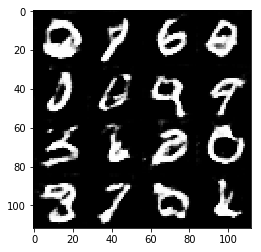

Epoch:2, Step:1500, Discriminator Loss:0.7782274484634399, Generator Loss:1.31959867477417
Epoch:2, Step:1510, Discriminator Loss:0.7688645720481873, Generator Loss:1.2586723566055298
Epoch:2, Step:1520, Discriminator Loss:0.8111398816108704, Generator Loss:1.1405134201049805
Epoch:2, Step:1530, Discriminator Loss:0.7287143468856812, Generator Loss:1.554764986038208
Epoch:2, Step:1540, Discriminator Loss:1.1979601383209229, Generator Loss:0.7868223786354065
Epoch:2, Step:1550, Discriminator Loss:0.8240220546722412, Generator Loss:2.2725889682769775
Epoch:2, Step:1560, Discriminator Loss:0.8564642667770386, Generator Loss:1.1187463998794556
Epoch:2, Step:1570, Discriminator Loss:0.7850987911224365, Generator Loss:1.3145591020584106
Epoch:2, Step:1580, Discriminator Loss:0.7557775378227234, Generator Loss:1.2964534759521484
Epoch:2, Step:1590, Discriminator Loss:0.6997897624969482, Generator Loss:1.4482587575912476


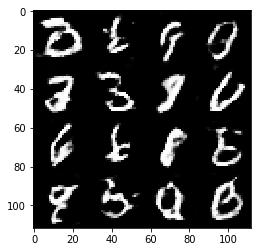

Epoch:2, Step:1600, Discriminator Loss:1.479677677154541, Generator Loss:0.5060092210769653
Epoch:2, Step:1610, Discriminator Loss:0.7426261901855469, Generator Loss:1.3626642227172852
Epoch:2, Step:1620, Discriminator Loss:1.0694169998168945, Generator Loss:0.7716875076293945
Epoch:2, Step:1630, Discriminator Loss:0.8608771562576294, Generator Loss:2.168034791946411
Epoch:2, Step:1640, Discriminator Loss:1.3379830121994019, Generator Loss:0.5854560136795044
Epoch:2, Step:1650, Discriminator Loss:0.7638390064239502, Generator Loss:1.2368855476379395
Epoch:2, Step:1660, Discriminator Loss:0.858344554901123, Generator Loss:1.0666828155517578
Epoch:2, Step:1670, Discriminator Loss:0.7962672710418701, Generator Loss:1.2158918380737305
Epoch:2, Step:1680, Discriminator Loss:1.4443436861038208, Generator Loss:3.621548891067505
Epoch:2, Step:1690, Discriminator Loss:0.6846048831939697, Generator Loss:1.7558815479278564


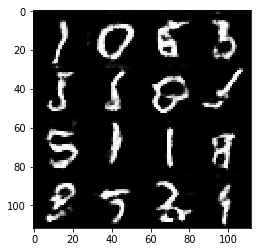

Epoch:2, Step:1700, Discriminator Loss:0.6998230218887329, Generator Loss:1.435423731803894
Epoch:2, Step:1710, Discriminator Loss:0.6386122703552246, Generator Loss:1.61667799949646
Epoch:2, Step:1720, Discriminator Loss:0.7259231805801392, Generator Loss:1.3349437713623047
Epoch:2, Step:1730, Discriminator Loss:0.8130989074707031, Generator Loss:1.1204736232757568
Epoch:2, Step:1740, Discriminator Loss:0.5479943752288818, Generator Loss:2.1217877864837646
Epoch:2, Step:1750, Discriminator Loss:0.6855326890945435, Generator Loss:1.4738340377807617
Epoch:2, Step:1760, Discriminator Loss:0.8252680897712708, Generator Loss:1.1969105005264282
Epoch:2, Step:1770, Discriminator Loss:0.5868296027183533, Generator Loss:1.775134801864624
Epoch:2, Step:1780, Discriminator Loss:0.7901579737663269, Generator Loss:2.8111915588378906
Epoch:2, Step:1790, Discriminator Loss:0.9135095477104187, Generator Loss:1.01141357421875


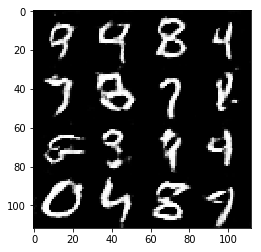

Epoch:2, Step:1800, Discriminator Loss:0.8150237202644348, Generator Loss:1.8788684606552124
Epoch:2, Step:1810, Discriminator Loss:0.6071481704711914, Generator Loss:2.1204683780670166
Epoch:2, Step:1820, Discriminator Loss:0.7215455770492554, Generator Loss:1.291711688041687
Epoch:2, Step:1830, Discriminator Loss:0.5860527753829956, Generator Loss:1.962162971496582
Epoch:2, Step:1840, Discriminator Loss:1.4870240688323975, Generator Loss:0.6594145894050598
Epoch:2, Step:1850, Discriminator Loss:0.7995672225952148, Generator Loss:1.1897573471069336
Epoch:2, Step:1860, Discriminator Loss:1.1389521360397339, Generator Loss:0.7015596628189087
Epoch:2, Step:1870, Discriminator Loss:1.1189079284667969, Generator Loss:0.7795100212097168


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:1, Step:10, Discriminator Loss:1.4576518535614014, Generator Loss:0.5067670941352844
Epoch:1, Step:20, Discriminator Loss:0.9888136386871338, Generator Loss:0.8903209567070007
Epoch:1, Step:30, Discriminator Loss:1.0515860319137573, Generator Loss:0.8277814984321594
Epoch:1, Step:40, Discriminator Loss:0.881854772567749, Generator Loss:0.9961434006690979
Epoch:1, Step:50, Discriminator Loss:0.5720526576042175, Generator Loss:1.951697826385498
Epoch:1, Step:60, Discriminator Loss:0.8395944833755493, Generator Loss:1.1127815246582031
Epoch:1, Step:70, Discriminator Loss:0.8242292404174805, Generator Loss:1.4268593788146973
Epoch:1, Step:80, Discriminator Loss:0.9797899723052979, Generator Loss:0.9185845255851746
Epoch:1, Step:90, Discriminator Loss:0.9936419129371643, Generator Loss:1.7705931663513184


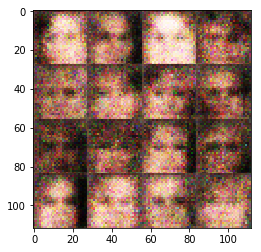

Epoch:1, Step:100, Discriminator Loss:1.5442782640457153, Generator Loss:0.4421951174736023
Epoch:1, Step:110, Discriminator Loss:1.4660587310791016, Generator Loss:0.45443686842918396
Epoch:1, Step:120, Discriminator Loss:0.9439668655395508, Generator Loss:1.0401084423065186
Epoch:1, Step:130, Discriminator Loss:1.525324821472168, Generator Loss:0.42765143513679504
Epoch:1, Step:140, Discriminator Loss:1.3101311922073364, Generator Loss:0.5734662413597107
Epoch:1, Step:150, Discriminator Loss:0.917223334312439, Generator Loss:1.167032241821289
Epoch:1, Step:160, Discriminator Loss:1.2138671875, Generator Loss:1.8459689617156982
Epoch:1, Step:170, Discriminator Loss:0.7689763903617859, Generator Loss:1.4946997165679932
Epoch:1, Step:180, Discriminator Loss:1.0137965679168701, Generator Loss:0.8623050451278687
Epoch:1, Step:190, Discriminator Loss:1.7682032585144043, Generator Loss:0.33430278301239014


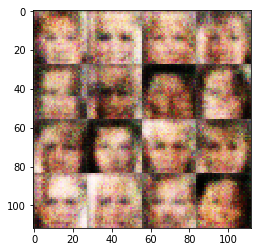

Epoch:1, Step:200, Discriminator Loss:1.031798243522644, Generator Loss:1.7159959077835083
Epoch:1, Step:210, Discriminator Loss:1.0010080337524414, Generator Loss:1.2159287929534912
Epoch:1, Step:220, Discriminator Loss:1.188128113746643, Generator Loss:0.67003333568573
Epoch:1, Step:230, Discriminator Loss:1.258742094039917, Generator Loss:1.216472864151001
Epoch:1, Step:240, Discriminator Loss:1.3840361833572388, Generator Loss:1.0510280132293701
Epoch:1, Step:250, Discriminator Loss:1.5972200632095337, Generator Loss:0.38189446926116943
Epoch:1, Step:260, Discriminator Loss:1.1009256839752197, Generator Loss:1.0108953714370728
Epoch:1, Step:270, Discriminator Loss:1.112133264541626, Generator Loss:0.8922141790390015
Epoch:1, Step:280, Discriminator Loss:1.607657551765442, Generator Loss:0.38896113634109497
Epoch:1, Step:290, Discriminator Loss:1.3110854625701904, Generator Loss:1.4334899187088013


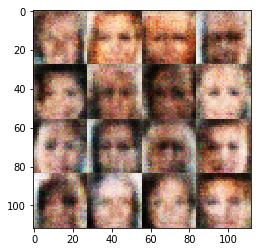

Epoch:1, Step:300, Discriminator Loss:1.2533777952194214, Generator Loss:0.6352828145027161
Epoch:1, Step:310, Discriminator Loss:1.3978252410888672, Generator Loss:1.2226452827453613
Epoch:1, Step:320, Discriminator Loss:1.5834805965423584, Generator Loss:0.40323886275291443
Epoch:1, Step:330, Discriminator Loss:1.1601636409759521, Generator Loss:1.463841438293457
Epoch:1, Step:340, Discriminator Loss:0.9715807437896729, Generator Loss:1.0932261943817139
Epoch:1, Step:350, Discriminator Loss:1.1289880275726318, Generator Loss:0.75318443775177
Epoch:1, Step:360, Discriminator Loss:1.089009404182434, Generator Loss:0.936921238899231
Epoch:1, Step:370, Discriminator Loss:1.1211128234863281, Generator Loss:0.8274586796760559
Epoch:1, Step:380, Discriminator Loss:0.906558096408844, Generator Loss:1.1242997646331787
Epoch:1, Step:390, Discriminator Loss:1.5229114294052124, Generator Loss:0.42688924074172974


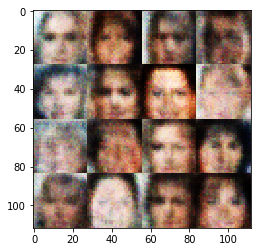

Epoch:1, Step:400, Discriminator Loss:1.3145318031311035, Generator Loss:0.5919243097305298
Epoch:1, Step:410, Discriminator Loss:1.2227661609649658, Generator Loss:1.0960001945495605
Epoch:1, Step:420, Discriminator Loss:1.1100038290023804, Generator Loss:0.9490108489990234
Epoch:1, Step:430, Discriminator Loss:1.1931099891662598, Generator Loss:0.6683440208435059
Epoch:1, Step:440, Discriminator Loss:1.595981240272522, Generator Loss:0.3966476023197174
Epoch:1, Step:450, Discriminator Loss:1.1893248558044434, Generator Loss:0.7291858792304993
Epoch:1, Step:460, Discriminator Loss:1.0847413539886475, Generator Loss:0.7963734269142151
Epoch:1, Step:470, Discriminator Loss:1.028681755065918, Generator Loss:1.5664751529693604
Epoch:1, Step:480, Discriminator Loss:1.2106871604919434, Generator Loss:0.648822546005249
Epoch:1, Step:490, Discriminator Loss:0.963859498500824, Generator Loss:0.9285631775856018


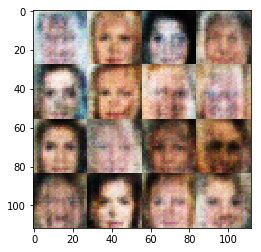

Epoch:1, Step:500, Discriminator Loss:1.2826714515686035, Generator Loss:1.3149911165237427
Epoch:1, Step:510, Discriminator Loss:1.4408295154571533, Generator Loss:0.498078852891922
Epoch:1, Step:520, Discriminator Loss:1.3133175373077393, Generator Loss:0.635564923286438
Epoch:1, Step:530, Discriminator Loss:1.2805289030075073, Generator Loss:0.6058974266052246
Epoch:1, Step:540, Discriminator Loss:1.346808910369873, Generator Loss:0.553061842918396
Epoch:1, Step:550, Discriminator Loss:1.1438096761703491, Generator Loss:0.7447495460510254
Epoch:1, Step:560, Discriminator Loss:1.4652857780456543, Generator Loss:0.48486241698265076
Epoch:1, Step:570, Discriminator Loss:0.9572531580924988, Generator Loss:1.2958004474639893
Epoch:1, Step:580, Discriminator Loss:1.428513765335083, Generator Loss:0.7167767882347107
Epoch:1, Step:590, Discriminator Loss:1.194456934928894, Generator Loss:0.9230633974075317


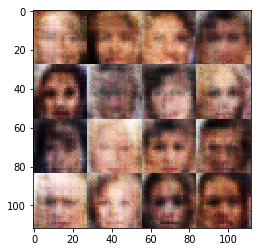

Epoch:1, Step:600, Discriminator Loss:1.0572172403335571, Generator Loss:0.8189553022384644
Epoch:1, Step:610, Discriminator Loss:1.3626859188079834, Generator Loss:0.5053045749664307
Epoch:1, Step:620, Discriminator Loss:1.3990181684494019, Generator Loss:0.5728293657302856
Epoch:1, Step:630, Discriminator Loss:1.2165899276733398, Generator Loss:0.9666534662246704
Epoch:1, Step:640, Discriminator Loss:1.3279035091400146, Generator Loss:0.8199602961540222
Epoch:1, Step:650, Discriminator Loss:1.441550612449646, Generator Loss:0.4622128903865814
Epoch:1, Step:660, Discriminator Loss:1.3206253051757812, Generator Loss:1.14467191696167
Epoch:1, Step:670, Discriminator Loss:1.048621416091919, Generator Loss:1.1723780632019043
Epoch:1, Step:680, Discriminator Loss:1.4421055316925049, Generator Loss:0.5738321542739868
Epoch:1, Step:690, Discriminator Loss:1.3904320001602173, Generator Loss:0.6770164370536804


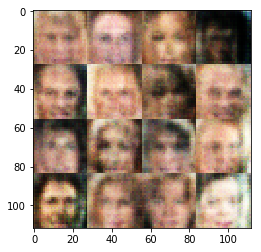

Epoch:1, Step:700, Discriminator Loss:1.3739433288574219, Generator Loss:0.7990192174911499
Epoch:1, Step:710, Discriminator Loss:1.1873247623443604, Generator Loss:0.9004752039909363
Epoch:1, Step:720, Discriminator Loss:1.426432728767395, Generator Loss:0.6666523814201355
Epoch:1, Step:730, Discriminator Loss:1.3296666145324707, Generator Loss:0.831324577331543
Epoch:1, Step:740, Discriminator Loss:1.329432487487793, Generator Loss:0.6490143537521362
Epoch:1, Step:750, Discriminator Loss:1.3434629440307617, Generator Loss:1.7696620225906372
Epoch:1, Step:760, Discriminator Loss:1.3606610298156738, Generator Loss:0.8841074705123901
Epoch:1, Step:770, Discriminator Loss:1.169992446899414, Generator Loss:0.8646290302276611
Epoch:1, Step:780, Discriminator Loss:1.1388672590255737, Generator Loss:1.1747925281524658
Epoch:1, Step:790, Discriminator Loss:1.2433687448501587, Generator Loss:0.9593571424484253


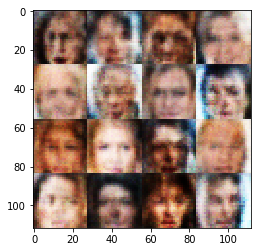

Epoch:1, Step:800, Discriminator Loss:1.2023189067840576, Generator Loss:1.016289472579956
Epoch:1, Step:810, Discriminator Loss:1.33035147190094, Generator Loss:0.5650937557220459
Epoch:1, Step:820, Discriminator Loss:1.25678288936615, Generator Loss:0.8664593696594238
Epoch:1, Step:830, Discriminator Loss:1.2727594375610352, Generator Loss:0.9079204797744751
Epoch:1, Step:840, Discriminator Loss:1.218628168106079, Generator Loss:0.7840312719345093
Epoch:1, Step:850, Discriminator Loss:1.2469183206558228, Generator Loss:0.931605875492096
Epoch:1, Step:860, Discriminator Loss:1.2910740375518799, Generator Loss:1.3722994327545166
Epoch:1, Step:870, Discriminator Loss:1.2834389209747314, Generator Loss:0.8473126888275146
Epoch:1, Step:880, Discriminator Loss:1.060423493385315, Generator Loss:0.8324952125549316
Epoch:1, Step:890, Discriminator Loss:1.2748212814331055, Generator Loss:0.6970945596694946


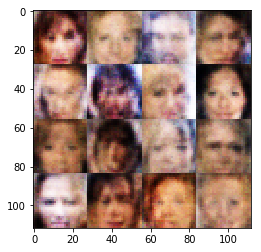

Epoch:1, Step:900, Discriminator Loss:1.3713868856430054, Generator Loss:0.5710793733596802
Epoch:1, Step:910, Discriminator Loss:1.2180731296539307, Generator Loss:0.6443722248077393
Epoch:1, Step:920, Discriminator Loss:1.6056585311889648, Generator Loss:0.5084943771362305
Epoch:1, Step:930, Discriminator Loss:1.1947147846221924, Generator Loss:0.7647591829299927
Epoch:1, Step:940, Discriminator Loss:1.256790280342102, Generator Loss:0.9105212092399597
Epoch:1, Step:950, Discriminator Loss:1.2119094133377075, Generator Loss:0.8839415311813354
Epoch:1, Step:960, Discriminator Loss:1.5441868305206299, Generator Loss:1.2857722043991089
Epoch:1, Step:970, Discriminator Loss:1.312738299369812, Generator Loss:0.7957873344421387
Epoch:1, Step:980, Discriminator Loss:1.2401800155639648, Generator Loss:0.8916751146316528
Epoch:1, Step:990, Discriminator Loss:1.2365124225616455, Generator Loss:0.7851701378822327


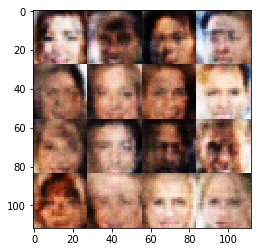

Epoch:1, Step:1000, Discriminator Loss:1.1969941854476929, Generator Loss:0.9282385110855103
Epoch:1, Step:1010, Discriminator Loss:1.146589756011963, Generator Loss:0.8218175172805786
Epoch:1, Step:1020, Discriminator Loss:1.177305817604065, Generator Loss:0.7068365216255188
Epoch:1, Step:1030, Discriminator Loss:1.5149917602539062, Generator Loss:0.44269824028015137
Epoch:1, Step:1040, Discriminator Loss:1.3546712398529053, Generator Loss:0.6807088851928711
Epoch:1, Step:1050, Discriminator Loss:1.2675365209579468, Generator Loss:1.466549277305603
Epoch:1, Step:1060, Discriminator Loss:1.1822197437286377, Generator Loss:1.0451403856277466
Epoch:1, Step:1070, Discriminator Loss:1.156482219696045, Generator Loss:1.3037056922912598
Epoch:1, Step:1080, Discriminator Loss:1.0999796390533447, Generator Loss:1.1032538414001465
Epoch:1, Step:1090, Discriminator Loss:1.0140912532806396, Generator Loss:1.0651516914367676


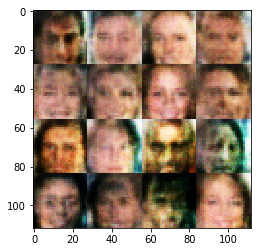

Epoch:1, Step:1100, Discriminator Loss:1.4612700939178467, Generator Loss:1.1871540546417236
Epoch:1, Step:1110, Discriminator Loss:1.168938159942627, Generator Loss:1.0195481777191162
Epoch:1, Step:1120, Discriminator Loss:1.0917084217071533, Generator Loss:0.9025740623474121
Epoch:1, Step:1130, Discriminator Loss:1.3915002346038818, Generator Loss:0.56725013256073
Epoch:1, Step:1140, Discriminator Loss:1.0584956407546997, Generator Loss:1.04756760597229
Epoch:1, Step:1150, Discriminator Loss:1.2333567142486572, Generator Loss:0.7719545364379883
Epoch:1, Step:1160, Discriminator Loss:1.1384098529815674, Generator Loss:0.9281728267669678
Epoch:1, Step:1170, Discriminator Loss:1.1224727630615234, Generator Loss:1.4406094551086426
Epoch:1, Step:1180, Discriminator Loss:1.0979406833648682, Generator Loss:1.0763293504714966
Epoch:1, Step:1190, Discriminator Loss:1.1212942600250244, Generator Loss:1.0633962154388428


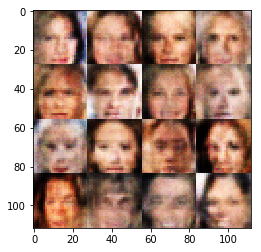

Epoch:1, Step:1200, Discriminator Loss:1.3039741516113281, Generator Loss:0.5878388285636902
Epoch:1, Step:1210, Discriminator Loss:1.248063325881958, Generator Loss:0.7612941265106201
Epoch:1, Step:1220, Discriminator Loss:1.2557786703109741, Generator Loss:0.8271248936653137
Epoch:1, Step:1230, Discriminator Loss:1.2203764915466309, Generator Loss:0.7463212013244629
Epoch:1, Step:1240, Discriminator Loss:1.0973666906356812, Generator Loss:0.9904305338859558
Epoch:1, Step:1250, Discriminator Loss:1.3657944202423096, Generator Loss:0.5441758036613464
Epoch:1, Step:1260, Discriminator Loss:1.1980037689208984, Generator Loss:0.7034622430801392
Epoch:1, Step:1270, Discriminator Loss:1.2844421863555908, Generator Loss:0.6400994062423706
Epoch:1, Step:1280, Discriminator Loss:1.087475299835205, Generator Loss:0.9380382895469666
Epoch:1, Step:1290, Discriminator Loss:1.2868738174438477, Generator Loss:0.6586616039276123


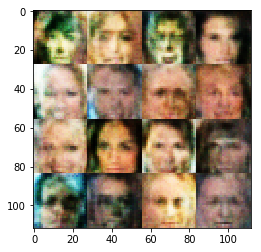

Epoch:1, Step:1300, Discriminator Loss:1.154991865158081, Generator Loss:0.7079955339431763
Epoch:1, Step:1310, Discriminator Loss:1.1024174690246582, Generator Loss:0.8325635194778442
Epoch:1, Step:1320, Discriminator Loss:1.112471580505371, Generator Loss:1.0879502296447754
Epoch:1, Step:1330, Discriminator Loss:1.1028037071228027, Generator Loss:1.1678919792175293
Epoch:1, Step:1340, Discriminator Loss:1.3936998844146729, Generator Loss:1.1027870178222656
Epoch:1, Step:1350, Discriminator Loss:1.3138315677642822, Generator Loss:0.6108472943305969
Epoch:1, Step:1360, Discriminator Loss:1.1925641298294067, Generator Loss:0.7198371887207031
Epoch:1, Step:1370, Discriminator Loss:1.3302876949310303, Generator Loss:0.5502356290817261
Epoch:1, Step:1380, Discriminator Loss:1.2114715576171875, Generator Loss:0.9976280927658081
Epoch:1, Step:1390, Discriminator Loss:1.1120517253875732, Generator Loss:0.8165178298950195


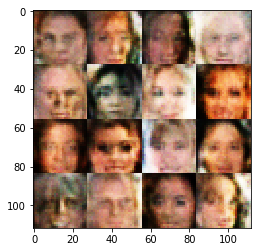

Epoch:1, Step:1400, Discriminator Loss:1.2456721067428589, Generator Loss:0.6523642539978027
Epoch:1, Step:1410, Discriminator Loss:1.0889153480529785, Generator Loss:1.0063380002975464
Epoch:1, Step:1420, Discriminator Loss:1.1201484203338623, Generator Loss:0.8321536183357239
Epoch:1, Step:1430, Discriminator Loss:1.249247670173645, Generator Loss:0.8278161287307739
Epoch:1, Step:1440, Discriminator Loss:1.1146762371063232, Generator Loss:0.9424250721931458
Epoch:1, Step:1450, Discriminator Loss:1.3302745819091797, Generator Loss:0.7556018233299255
Epoch:1, Step:1460, Discriminator Loss:1.033174991607666, Generator Loss:1.0740658044815063
Epoch:1, Step:1470, Discriminator Loss:1.409120798110962, Generator Loss:0.5350513458251953
Epoch:1, Step:1480, Discriminator Loss:1.0417239665985107, Generator Loss:1.0678097009658813
Epoch:1, Step:1490, Discriminator Loss:1.2000231742858887, Generator Loss:0.9521922469139099


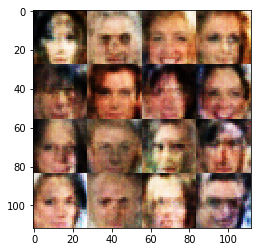

Epoch:1, Step:1500, Discriminator Loss:1.1912140846252441, Generator Loss:0.7736576795578003
Epoch:1, Step:1510, Discriminator Loss:1.1451153755187988, Generator Loss:1.1435887813568115
Epoch:1, Step:1520, Discriminator Loss:1.1432925462722778, Generator Loss:0.818676233291626
Epoch:1, Step:1530, Discriminator Loss:1.1748969554901123, Generator Loss:0.7271361351013184
Epoch:1, Step:1540, Discriminator Loss:1.3473588228225708, Generator Loss:0.619742214679718
Epoch:1, Step:1550, Discriminator Loss:1.390763521194458, Generator Loss:0.5482147932052612
Epoch:1, Step:1560, Discriminator Loss:1.2854920625686646, Generator Loss:1.0422065258026123
Epoch:1, Step:1570, Discriminator Loss:1.2480963468551636, Generator Loss:0.7958616018295288
Epoch:1, Step:1580, Discriminator Loss:1.118520736694336, Generator Loss:0.8384215831756592
Epoch:1, Step:1590, Discriminator Loss:1.4009110927581787, Generator Loss:0.540797233581543


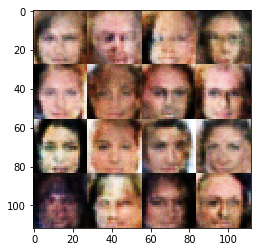

Epoch:1, Step:1600, Discriminator Loss:1.2071316242218018, Generator Loss:0.6772027015686035
Epoch:1, Step:1610, Discriminator Loss:1.4299668073654175, Generator Loss:0.5255908966064453
Epoch:1, Step:1620, Discriminator Loss:1.0395481586456299, Generator Loss:0.8344109654426575
Epoch:1, Step:1630, Discriminator Loss:1.1369340419769287, Generator Loss:0.8805972337722778
Epoch:1, Step:1640, Discriminator Loss:1.262631893157959, Generator Loss:0.6252105832099915
Epoch:1, Step:1650, Discriminator Loss:1.1552937030792236, Generator Loss:1.3400907516479492
Epoch:1, Step:1660, Discriminator Loss:1.2791290283203125, Generator Loss:0.6284846067428589
Epoch:1, Step:1670, Discriminator Loss:1.2592607736587524, Generator Loss:0.6259080171585083
Epoch:1, Step:1680, Discriminator Loss:1.156196117401123, Generator Loss:0.7978924512863159
Epoch:1, Step:1690, Discriminator Loss:1.1134006977081299, Generator Loss:0.7685247659683228


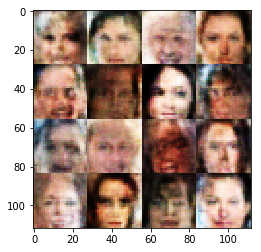

Epoch:1, Step:1700, Discriminator Loss:1.309302806854248, Generator Loss:0.6009323596954346
Epoch:1, Step:1710, Discriminator Loss:1.1314811706542969, Generator Loss:0.7184129953384399
Epoch:1, Step:1720, Discriminator Loss:1.3257625102996826, Generator Loss:0.5792572498321533
Epoch:1, Step:1730, Discriminator Loss:1.2779717445373535, Generator Loss:0.7129170894622803
Epoch:1, Step:1740, Discriminator Loss:1.30661940574646, Generator Loss:0.782804012298584
Epoch:1, Step:1750, Discriminator Loss:1.200210452079773, Generator Loss:0.6456401348114014
Epoch:1, Step:1760, Discriminator Loss:1.3967821598052979, Generator Loss:0.7275669574737549
Epoch:1, Step:1770, Discriminator Loss:1.1272389888763428, Generator Loss:0.7832258343696594
Epoch:1, Step:1780, Discriminator Loss:1.265899658203125, Generator Loss:0.7294445633888245
Epoch:1, Step:1790, Discriminator Loss:1.198197364807129, Generator Loss:0.7136775851249695


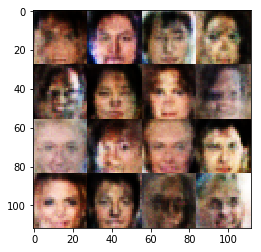

Epoch:1, Step:1800, Discriminator Loss:1.0896155834197998, Generator Loss:1.1885459423065186
Epoch:1, Step:1810, Discriminator Loss:1.0933464765548706, Generator Loss:0.9380375146865845
Epoch:1, Step:1820, Discriminator Loss:1.3490771055221558, Generator Loss:0.6763013601303101
Epoch:1, Step:1830, Discriminator Loss:1.3111488819122314, Generator Loss:0.5972806215286255
Epoch:1, Step:1840, Discriminator Loss:1.2001169919967651, Generator Loss:0.6953432559967041
Epoch:1, Step:1850, Discriminator Loss:1.1074637174606323, Generator Loss:1.0254933834075928
Epoch:1, Step:1860, Discriminator Loss:1.1984626054763794, Generator Loss:0.8025567531585693
Epoch:1, Step:1870, Discriminator Loss:1.263106346130371, Generator Loss:0.7866684794425964
Epoch:1, Step:1880, Discriminator Loss:1.602391242980957, Generator Loss:0.4322267770767212
Epoch:1, Step:1890, Discriminator Loss:1.1501611471176147, Generator Loss:0.8703358173370361


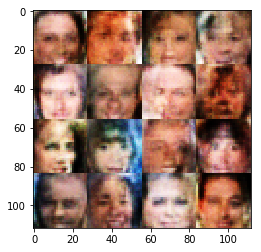

Epoch:1, Step:1900, Discriminator Loss:1.3363728523254395, Generator Loss:0.6782277226448059
Epoch:1, Step:1910, Discriminator Loss:1.314918041229248, Generator Loss:0.9578917622566223
Epoch:1, Step:1920, Discriminator Loss:1.3057736158370972, Generator Loss:0.9013658761978149
Epoch:1, Step:1930, Discriminator Loss:1.2956293821334839, Generator Loss:0.6459699869155884
Epoch:1, Step:1940, Discriminator Loss:1.1883342266082764, Generator Loss:1.2158801555633545
Epoch:1, Step:1950, Discriminator Loss:1.2612189054489136, Generator Loss:0.7265413999557495
Epoch:1, Step:1960, Discriminator Loss:1.1118601560592651, Generator Loss:1.0057532787322998
Epoch:1, Step:1970, Discriminator Loss:1.1879336833953857, Generator Loss:0.9888010025024414
Epoch:1, Step:1980, Discriminator Loss:1.6079021692276, Generator Loss:0.4244149625301361
Epoch:1, Step:1990, Discriminator Loss:1.0830124616622925, Generator Loss:1.030515432357788


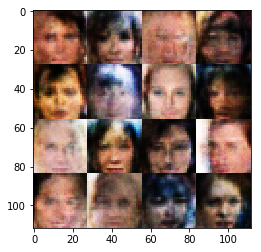

Epoch:1, Step:2000, Discriminator Loss:1.1708452701568604, Generator Loss:0.924483597278595
Epoch:1, Step:2010, Discriminator Loss:1.1498987674713135, Generator Loss:1.0104293823242188
Epoch:1, Step:2020, Discriminator Loss:1.412007212638855, Generator Loss:0.5708577632904053
Epoch:1, Step:2030, Discriminator Loss:1.3512346744537354, Generator Loss:0.5305732488632202
Epoch:1, Step:2040, Discriminator Loss:1.1225563287734985, Generator Loss:1.2014987468719482
Epoch:1, Step:2050, Discriminator Loss:1.5743536949157715, Generator Loss:0.4444439113140106
Epoch:1, Step:2060, Discriminator Loss:1.0371427536010742, Generator Loss:1.131692886352539
Epoch:1, Step:2070, Discriminator Loss:1.2847099304199219, Generator Loss:0.7483464479446411
Epoch:1, Step:2080, Discriminator Loss:1.0833802223205566, Generator Loss:1.1761980056762695
Epoch:1, Step:2090, Discriminator Loss:1.1203644275665283, Generator Loss:1.1289031505584717


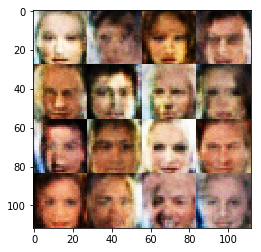

Epoch:1, Step:2100, Discriminator Loss:1.4740492105484009, Generator Loss:1.0221033096313477
Epoch:1, Step:2110, Discriminator Loss:0.9989057779312134, Generator Loss:0.8369736671447754
Epoch:1, Step:2120, Discriminator Loss:1.2691493034362793, Generator Loss:0.7070845365524292
Epoch:1, Step:2130, Discriminator Loss:1.0218920707702637, Generator Loss:1.2346162796020508
Epoch:1, Step:2140, Discriminator Loss:1.4634181261062622, Generator Loss:0.46461182832717896
Epoch:1, Step:2150, Discriminator Loss:1.2099545001983643, Generator Loss:0.8062313795089722
Epoch:1, Step:2160, Discriminator Loss:1.1192264556884766, Generator Loss:0.8022609353065491
Epoch:1, Step:2170, Discriminator Loss:1.0296217203140259, Generator Loss:1.1189996004104614
Epoch:1, Step:2180, Discriminator Loss:1.307554841041565, Generator Loss:0.617800772190094
Epoch:1, Step:2190, Discriminator Loss:1.3082997798919678, Generator Loss:0.5658966302871704


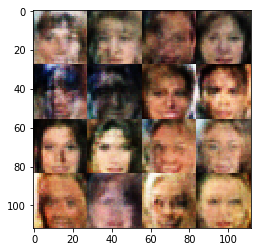

Epoch:1, Step:2200, Discriminator Loss:1.2760920524597168, Generator Loss:0.738798975944519
Epoch:1, Step:2210, Discriminator Loss:1.190211296081543, Generator Loss:0.7394276857376099
Epoch:1, Step:2220, Discriminator Loss:1.1270406246185303, Generator Loss:0.7928972840309143
Epoch:1, Step:2230, Discriminator Loss:1.3478392362594604, Generator Loss:0.5741217136383057
Epoch:1, Step:2240, Discriminator Loss:1.1796579360961914, Generator Loss:1.2684247493743896
Epoch:1, Step:2250, Discriminator Loss:1.2030428647994995, Generator Loss:0.7164629101753235
Epoch:1, Step:2260, Discriminator Loss:1.1519368886947632, Generator Loss:0.7215465307235718
Epoch:1, Step:2270, Discriminator Loss:1.5580519437789917, Generator Loss:0.4240076243877411
Epoch:1, Step:2280, Discriminator Loss:0.9827378988265991, Generator Loss:1.2260570526123047
Epoch:1, Step:2290, Discriminator Loss:1.2063251733779907, Generator Loss:0.64771968126297


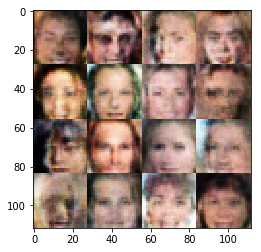

Epoch:1, Step:2300, Discriminator Loss:1.1803462505340576, Generator Loss:0.9470049142837524
Epoch:1, Step:2310, Discriminator Loss:1.1667808294296265, Generator Loss:0.8027743101119995
Epoch:1, Step:2320, Discriminator Loss:1.2364517450332642, Generator Loss:0.7231711149215698
Epoch:1, Step:2330, Discriminator Loss:1.1835757493972778, Generator Loss:1.0209825038909912
Epoch:1, Step:2340, Discriminator Loss:1.120338797569275, Generator Loss:0.7206448912620544
Epoch:1, Step:2350, Discriminator Loss:1.2118486166000366, Generator Loss:0.8011308908462524
Epoch:1, Step:2360, Discriminator Loss:0.9807352423667908, Generator Loss:0.9683294296264648
Epoch:1, Step:2370, Discriminator Loss:1.0657086372375488, Generator Loss:0.9592453241348267
Epoch:1, Step:2380, Discriminator Loss:1.137347936630249, Generator Loss:1.1478993892669678
Epoch:1, Step:2390, Discriminator Loss:1.3997514247894287, Generator Loss:0.5514414310455322


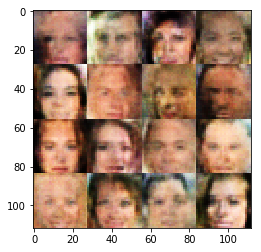

Epoch:1, Step:2400, Discriminator Loss:1.3215466737747192, Generator Loss:0.5874375104904175
Epoch:1, Step:2410, Discriminator Loss:1.1521332263946533, Generator Loss:0.7584502696990967
Epoch:1, Step:2420, Discriminator Loss:1.3108208179473877, Generator Loss:0.6252055168151855
Epoch:1, Step:2430, Discriminator Loss:0.942273736000061, Generator Loss:1.0757200717926025
Epoch:1, Step:2440, Discriminator Loss:1.140620231628418, Generator Loss:0.798267126083374
Epoch:1, Step:2450, Discriminator Loss:1.3076120615005493, Generator Loss:0.6210273504257202
Epoch:1, Step:2460, Discriminator Loss:1.1894389390945435, Generator Loss:0.7658287286758423
Epoch:1, Step:2470, Discriminator Loss:1.1568937301635742, Generator Loss:0.7342451214790344
Epoch:1, Step:2480, Discriminator Loss:1.1078814268112183, Generator Loss:0.773126482963562
Epoch:1, Step:2490, Discriminator Loss:1.2345994710922241, Generator Loss:0.7407466173171997


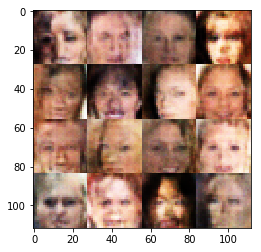

Epoch:1, Step:2500, Discriminator Loss:1.0380884408950806, Generator Loss:1.203383207321167
Epoch:1, Step:2510, Discriminator Loss:1.1112507581710815, Generator Loss:1.0882270336151123
Epoch:1, Step:2520, Discriminator Loss:1.0352566242218018, Generator Loss:0.947761058807373
Epoch:1, Step:2530, Discriminator Loss:1.262941837310791, Generator Loss:0.5917202234268188
Epoch:1, Step:2540, Discriminator Loss:1.257132887840271, Generator Loss:0.6876158118247986
Epoch:1, Step:2550, Discriminator Loss:1.2665586471557617, Generator Loss:0.6121021509170532
Epoch:1, Step:2560, Discriminator Loss:1.0545233488082886, Generator Loss:0.9304201006889343
Epoch:1, Step:2570, Discriminator Loss:1.3360629081726074, Generator Loss:0.522625207901001
Epoch:1, Step:2580, Discriminator Loss:1.3397126197814941, Generator Loss:0.5059573650360107
Epoch:1, Step:2590, Discriminator Loss:1.153653621673584, Generator Loss:0.8994934558868408


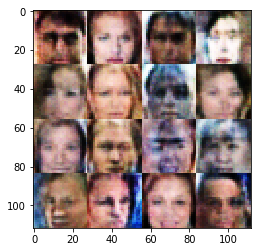

Epoch:1, Step:2600, Discriminator Loss:0.972339928150177, Generator Loss:1.0020955801010132
Epoch:1, Step:2610, Discriminator Loss:1.320033073425293, Generator Loss:0.6432103514671326
Epoch:1, Step:2620, Discriminator Loss:1.5123493671417236, Generator Loss:0.41807079315185547
Epoch:1, Step:2630, Discriminator Loss:1.1309773921966553, Generator Loss:0.7903128266334534
Epoch:1, Step:2640, Discriminator Loss:1.0551366806030273, Generator Loss:0.8371525406837463
Epoch:1, Step:2650, Discriminator Loss:1.1976287364959717, Generator Loss:0.6592535972595215
Epoch:1, Step:2660, Discriminator Loss:1.2102292776107788, Generator Loss:0.7317199110984802
Epoch:1, Step:2670, Discriminator Loss:1.2767412662506104, Generator Loss:0.9605565071105957
Epoch:1, Step:2680, Discriminator Loss:1.250922679901123, Generator Loss:0.971330463886261
Epoch:1, Step:2690, Discriminator Loss:1.246138334274292, Generator Loss:0.7833906412124634


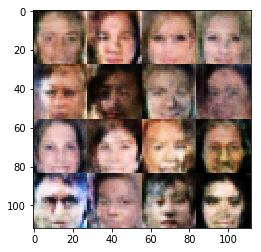

Epoch:1, Step:2700, Discriminator Loss:1.4453785419464111, Generator Loss:0.45911791920661926
Epoch:1, Step:2710, Discriminator Loss:1.2166112661361694, Generator Loss:0.7115119695663452
Epoch:1, Step:2720, Discriminator Loss:1.3560155630111694, Generator Loss:0.7681089639663696
Epoch:1, Step:2730, Discriminator Loss:1.090829849243164, Generator Loss:0.8395299911499023
Epoch:1, Step:2740, Discriminator Loss:1.2010929584503174, Generator Loss:0.7887371182441711
Epoch:1, Step:2750, Discriminator Loss:1.178985595703125, Generator Loss:1.1278473138809204
Epoch:1, Step:2760, Discriminator Loss:1.239102840423584, Generator Loss:0.6536126136779785
Epoch:1, Step:2770, Discriminator Loss:1.2319873571395874, Generator Loss:0.6458210945129395
Epoch:1, Step:2780, Discriminator Loss:1.213242769241333, Generator Loss:0.7784561514854431
Epoch:1, Step:2790, Discriminator Loss:1.2745428085327148, Generator Loss:0.763377845287323


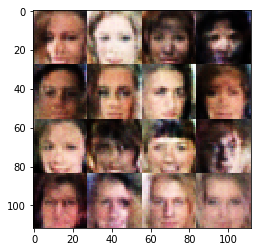

Epoch:1, Step:2800, Discriminator Loss:1.2318532466888428, Generator Loss:0.6573536396026611
Epoch:1, Step:2810, Discriminator Loss:1.0699262619018555, Generator Loss:0.9986053705215454
Epoch:1, Step:2820, Discriminator Loss:1.1016876697540283, Generator Loss:0.7802704572677612
Epoch:1, Step:2830, Discriminator Loss:1.2681026458740234, Generator Loss:0.7492560148239136
Epoch:1, Step:2840, Discriminator Loss:1.3923983573913574, Generator Loss:0.5094618797302246
Epoch:1, Step:2850, Discriminator Loss:1.1326195001602173, Generator Loss:0.9010032415390015
Epoch:1, Step:2860, Discriminator Loss:1.1735680103302002, Generator Loss:1.3136498928070068
Epoch:1, Step:2870, Discriminator Loss:1.0898168087005615, Generator Loss:0.9126380681991577
Epoch:1, Step:2880, Discriminator Loss:1.2423876523971558, Generator Loss:0.6686169505119324
Epoch:1, Step:2890, Discriminator Loss:1.1958683729171753, Generator Loss:0.9480909109115601


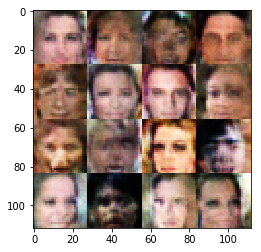

Epoch:1, Step:2900, Discriminator Loss:1.1603007316589355, Generator Loss:0.7646929621696472
Epoch:1, Step:2910, Discriminator Loss:1.0612785816192627, Generator Loss:0.956516444683075
Epoch:1, Step:2920, Discriminator Loss:1.2281532287597656, Generator Loss:0.7439388036727905
Epoch:1, Step:2930, Discriminator Loss:1.0485719442367554, Generator Loss:0.8350443840026855
Epoch:1, Step:2940, Discriminator Loss:1.0669140815734863, Generator Loss:1.1674127578735352
Epoch:1, Step:2950, Discriminator Loss:1.0950355529785156, Generator Loss:0.8631925582885742
Epoch:1, Step:2960, Discriminator Loss:1.1212650537490845, Generator Loss:0.815454363822937
Epoch:1, Step:2970, Discriminator Loss:1.0945149660110474, Generator Loss:0.8064852952957153
Epoch:1, Step:2980, Discriminator Loss:1.337428092956543, Generator Loss:0.5878845453262329
Epoch:1, Step:2990, Discriminator Loss:1.0617384910583496, Generator Loss:0.9502536058425903


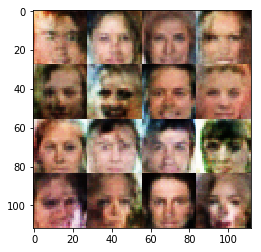

Epoch:1, Step:3000, Discriminator Loss:1.375276803970337, Generator Loss:0.5945413112640381
Epoch:1, Step:3010, Discriminator Loss:1.1906473636627197, Generator Loss:0.7577663660049438
Epoch:1, Step:3020, Discriminator Loss:0.9512653350830078, Generator Loss:1.1037458181381226
Epoch:1, Step:3030, Discriminator Loss:0.8082884550094604, Generator Loss:1.123354434967041
Epoch:1, Step:3040, Discriminator Loss:1.1000277996063232, Generator Loss:1.0033106803894043
Epoch:1, Step:3050, Discriminator Loss:1.1545157432556152, Generator Loss:0.7431038618087769
Epoch:1, Step:3060, Discriminator Loss:0.9299880266189575, Generator Loss:1.2774858474731445
Epoch:1, Step:3070, Discriminator Loss:1.294398307800293, Generator Loss:0.6542723178863525
Epoch:1, Step:3080, Discriminator Loss:1.5320637226104736, Generator Loss:0.44262373447418213
Epoch:1, Step:3090, Discriminator Loss:0.8183830380439758, Generator Loss:1.197668194770813


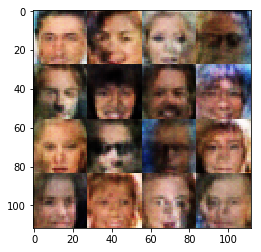

Epoch:1, Step:3100, Discriminator Loss:1.2344160079956055, Generator Loss:0.7388492822647095
Epoch:1, Step:3110, Discriminator Loss:0.8307054042816162, Generator Loss:1.3669629096984863
Epoch:1, Step:3120, Discriminator Loss:1.6686580181121826, Generator Loss:0.3681875765323639
Epoch:1, Step:3130, Discriminator Loss:1.3804984092712402, Generator Loss:0.5282891988754272
Epoch:1, Step:3140, Discriminator Loss:1.0326838493347168, Generator Loss:0.9950893521308899
Epoch:1, Step:3150, Discriminator Loss:0.997452974319458, Generator Loss:1.0113983154296875
Epoch:1, Step:3160, Discriminator Loss:1.2383060455322266, Generator Loss:0.6401358842849731
Epoch:1, Step:3170, Discriminator Loss:1.2775719165802002, Generator Loss:0.5574154257774353
Epoch:1, Step:3180, Discriminator Loss:1.0248374938964844, Generator Loss:1.2015503644943237
Epoch:1, Step:3190, Discriminator Loss:1.5980899333953857, Generator Loss:0.3853878080844879


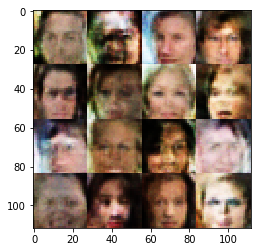

Epoch:1, Step:3200, Discriminator Loss:0.9394977688789368, Generator Loss:1.261548638343811
Epoch:1, Step:3210, Discriminator Loss:1.3302464485168457, Generator Loss:0.7206103205680847
Epoch:1, Step:3220, Discriminator Loss:1.25589919090271, Generator Loss:0.6215851306915283
Epoch:1, Step:3230, Discriminator Loss:1.146054983139038, Generator Loss:0.9519167542457581
Epoch:1, Step:3240, Discriminator Loss:1.1914291381835938, Generator Loss:0.6777231693267822
Epoch:1, Step:3250, Discriminator Loss:0.9076264500617981, Generator Loss:1.0996649265289307
Epoch:1, Step:3260, Discriminator Loss:0.955263078212738, Generator Loss:1.8696974515914917
Epoch:1, Step:3270, Discriminator Loss:1.3074498176574707, Generator Loss:0.7234781980514526
Epoch:1, Step:3280, Discriminator Loss:0.9246628284454346, Generator Loss:1.0221400260925293
Epoch:1, Step:3290, Discriminator Loss:1.246233344078064, Generator Loss:0.7040917873382568


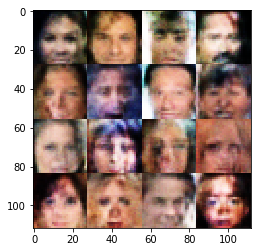

Epoch:1, Step:3300, Discriminator Loss:1.1950900554656982, Generator Loss:0.6226403117179871
Epoch:1, Step:3310, Discriminator Loss:1.1206694841384888, Generator Loss:0.931433916091919
Epoch:1, Step:3320, Discriminator Loss:1.218102216720581, Generator Loss:0.6163718700408936
Epoch:1, Step:3330, Discriminator Loss:1.339219570159912, Generator Loss:0.5476454496383667
Epoch:1, Step:3340, Discriminator Loss:1.4568235874176025, Generator Loss:0.5218791365623474
Epoch:1, Step:3350, Discriminator Loss:1.2002196311950684, Generator Loss:0.7180595397949219
Epoch:1, Step:3360, Discriminator Loss:1.0410391092300415, Generator Loss:0.7784673571586609
Epoch:1, Step:3370, Discriminator Loss:1.0639374256134033, Generator Loss:0.940922737121582
Epoch:1, Step:3380, Discriminator Loss:1.2291436195373535, Generator Loss:1.0866024494171143
Epoch:1, Step:3390, Discriminator Loss:1.287750005722046, Generator Loss:0.5536229610443115


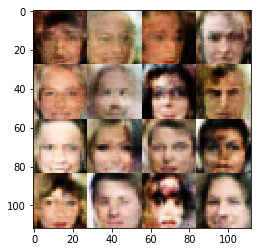

Epoch:1, Step:3400, Discriminator Loss:1.4523890018463135, Generator Loss:0.48110145330429077
Epoch:1, Step:3410, Discriminator Loss:1.1547549962997437, Generator Loss:0.7946776747703552
Epoch:1, Step:3420, Discriminator Loss:1.2180436849594116, Generator Loss:1.098697543144226
Epoch:1, Step:3430, Discriminator Loss:1.166459321975708, Generator Loss:0.7265442609786987
Epoch:1, Step:3440, Discriminator Loss:1.361841082572937, Generator Loss:0.6962752342224121
Epoch:1, Step:3450, Discriminator Loss:1.7085652351379395, Generator Loss:0.32306724786758423
Epoch:1, Step:3460, Discriminator Loss:1.0424530506134033, Generator Loss:0.9765990376472473
Epoch:1, Step:3470, Discriminator Loss:1.3053816556930542, Generator Loss:0.5943766832351685
Epoch:1, Step:3480, Discriminator Loss:1.243869662284851, Generator Loss:0.6364760398864746
Epoch:1, Step:3490, Discriminator Loss:1.125871181488037, Generator Loss:0.7907912135124207


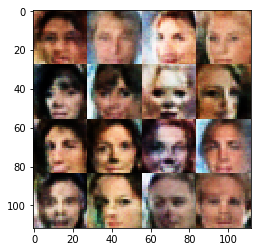

Epoch:1, Step:3500, Discriminator Loss:1.235856294631958, Generator Loss:0.8644811511039734
Epoch:1, Step:3510, Discriminator Loss:1.214282751083374, Generator Loss:0.6701481342315674
Epoch:1, Step:3520, Discriminator Loss:0.823078453540802, Generator Loss:1.2934930324554443
Epoch:1, Step:3530, Discriminator Loss:1.5118805170059204, Generator Loss:0.40035223960876465
Epoch:1, Step:3540, Discriminator Loss:1.2286720275878906, Generator Loss:0.8155839443206787
Epoch:1, Step:3550, Discriminator Loss:1.0566445589065552, Generator Loss:0.8732929229736328
Epoch:1, Step:3560, Discriminator Loss:1.0212225914001465, Generator Loss:1.0774391889572144
Epoch:1, Step:3570, Discriminator Loss:1.033111572265625, Generator Loss:0.8513160347938538
Epoch:1, Step:3580, Discriminator Loss:1.4948339462280273, Generator Loss:0.48200541734695435
Epoch:1, Step:3590, Discriminator Loss:0.84166419506073, Generator Loss:1.5365993976593018


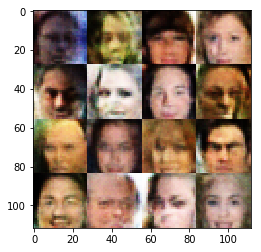

Epoch:1, Step:3600, Discriminator Loss:1.407523274421692, Generator Loss:0.49419423937797546
Epoch:1, Step:3610, Discriminator Loss:0.9747012853622437, Generator Loss:1.1395857334136963
Epoch:1, Step:3620, Discriminator Loss:0.6515207886695862, Generator Loss:1.5172020196914673
Epoch:1, Step:3630, Discriminator Loss:1.9447249174118042, Generator Loss:0.24947762489318848
Epoch:1, Step:3640, Discriminator Loss:0.9218031167984009, Generator Loss:1.199941635131836
Epoch:1, Step:3650, Discriminator Loss:1.0334142446517944, Generator Loss:1.5795209407806396
Epoch:1, Step:3660, Discriminator Loss:1.0245221853256226, Generator Loss:0.9397188425064087
Epoch:1, Step:3670, Discriminator Loss:0.7688879370689392, Generator Loss:1.8888351917266846
Epoch:1, Step:3680, Discriminator Loss:1.4160703420639038, Generator Loss:0.4652186930179596
Epoch:1, Step:3690, Discriminator Loss:1.1444147825241089, Generator Loss:1.5379140377044678


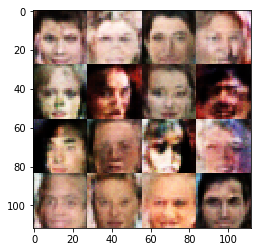

Epoch:1, Step:3700, Discriminator Loss:1.021716833114624, Generator Loss:2.013645648956299
Epoch:1, Step:3710, Discriminator Loss:0.9315130710601807, Generator Loss:1.4734535217285156
Epoch:1, Step:3720, Discriminator Loss:0.8770374059677124, Generator Loss:1.1375484466552734
Epoch:1, Step:3730, Discriminator Loss:1.2390738725662231, Generator Loss:1.6639611721038818
Epoch:1, Step:3740, Discriminator Loss:1.3682693243026733, Generator Loss:0.5376369953155518
Epoch:1, Step:3750, Discriminator Loss:1.3384391069412231, Generator Loss:0.536787748336792
Epoch:1, Step:3760, Discriminator Loss:1.041032075881958, Generator Loss:0.7944071888923645
Epoch:1, Step:3770, Discriminator Loss:0.8135536313056946, Generator Loss:1.1072213649749756
Epoch:1, Step:3780, Discriminator Loss:1.2358143329620361, Generator Loss:0.5911089181900024
Epoch:1, Step:3790, Discriminator Loss:0.8570593595504761, Generator Loss:1.1592341661453247


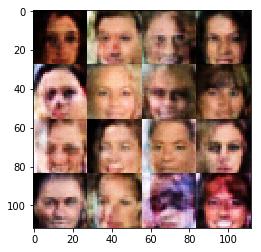

Epoch:1, Step:3800, Discriminator Loss:1.146773338317871, Generator Loss:0.7372459769248962
Epoch:1, Step:3810, Discriminator Loss:0.9831709861755371, Generator Loss:2.0986125469207764
Epoch:1, Step:3820, Discriminator Loss:1.166275978088379, Generator Loss:0.6226692199707031
Epoch:1, Step:3830, Discriminator Loss:0.995102047920227, Generator Loss:1.152613878250122
Epoch:1, Step:3840, Discriminator Loss:1.257954716682434, Generator Loss:0.5926780700683594
Epoch:1, Step:3850, Discriminator Loss:1.0450412034988403, Generator Loss:0.929082453250885
Epoch:1, Step:3860, Discriminator Loss:1.0333445072174072, Generator Loss:0.82616126537323
Epoch:1, Step:3870, Discriminator Loss:1.5066275596618652, Generator Loss:0.47327589988708496
Epoch:1, Step:3880, Discriminator Loss:1.0253894329071045, Generator Loss:2.2571463584899902
Epoch:1, Step:3890, Discriminator Loss:0.8521215915679932, Generator Loss:1.1477441787719727


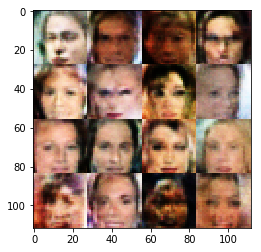

Epoch:1, Step:3900, Discriminator Loss:1.0476620197296143, Generator Loss:0.7541824579238892
Epoch:1, Step:3910, Discriminator Loss:0.8078848123550415, Generator Loss:1.2137054204940796
Epoch:1, Step:3920, Discriminator Loss:0.6964799165725708, Generator Loss:1.9025800228118896
Epoch:1, Step:3930, Discriminator Loss:1.6874580383300781, Generator Loss:0.34387773275375366
Epoch:1, Step:3940, Discriminator Loss:0.8116492629051208, Generator Loss:1.3974509239196777
Epoch:1, Step:3950, Discriminator Loss:1.0644246339797974, Generator Loss:1.212824821472168
Epoch:1, Step:3960, Discriminator Loss:1.5710901021957397, Generator Loss:0.38161906599998474
Epoch:1, Step:3970, Discriminator Loss:1.0442116260528564, Generator Loss:1.2742633819580078
Epoch:1, Step:3980, Discriminator Loss:1.008921504020691, Generator Loss:1.2423655986785889
Epoch:1, Step:3990, Discriminator Loss:0.8962967395782471, Generator Loss:1.1528942584991455


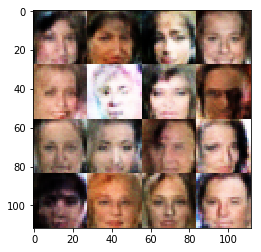

Epoch:1, Step:4000, Discriminator Loss:1.1704565286636353, Generator Loss:1.0825265645980835
Epoch:1, Step:4010, Discriminator Loss:0.9144223928451538, Generator Loss:0.9381064772605896
Epoch:1, Step:4020, Discriminator Loss:1.3791682720184326, Generator Loss:1.9681406021118164
Epoch:1, Step:4030, Discriminator Loss:0.679847002029419, Generator Loss:1.566148281097412
Epoch:1, Step:4040, Discriminator Loss:0.8120980858802795, Generator Loss:1.069068193435669
Epoch:1, Step:4050, Discriminator Loss:1.4240832328796387, Generator Loss:0.500533401966095
Epoch:1, Step:4060, Discriminator Loss:1.1137620210647583, Generator Loss:0.6882455348968506
Epoch:1, Step:4070, Discriminator Loss:0.9670689105987549, Generator Loss:1.651825189590454
Epoch:1, Step:4080, Discriminator Loss:0.6771472096443176, Generator Loss:2.612217426300049
Epoch:1, Step:4090, Discriminator Loss:1.6182055473327637, Generator Loss:0.45678606629371643


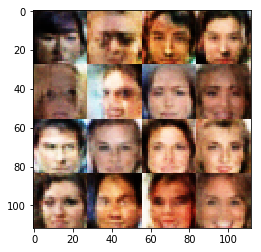

Epoch:1, Step:4100, Discriminator Loss:0.9352928996086121, Generator Loss:1.3835216760635376
Epoch:1, Step:4110, Discriminator Loss:0.7410702109336853, Generator Loss:1.7616686820983887
Epoch:1, Step:4120, Discriminator Loss:0.57013338804245, Generator Loss:2.1258511543273926
Epoch:1, Step:4130, Discriminator Loss:1.1780837774276733, Generator Loss:1.8122272491455078
Epoch:1, Step:4140, Discriminator Loss:0.6567362546920776, Generator Loss:2.398681402206421
Epoch:1, Step:4150, Discriminator Loss:1.673513412475586, Generator Loss:0.3441981077194214
Epoch:1, Step:4160, Discriminator Loss:2.1469295024871826, Generator Loss:0.19532561302185059
Epoch:1, Step:4170, Discriminator Loss:1.2334035634994507, Generator Loss:1.5319232940673828
Epoch:1, Step:4180, Discriminator Loss:0.7087737321853638, Generator Loss:2.1656367778778076
Epoch:1, Step:4190, Discriminator Loss:0.7304644584655762, Generator Loss:1.446315050125122


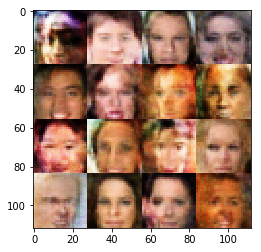

Epoch:1, Step:4200, Discriminator Loss:0.7508247494697571, Generator Loss:1.3036816120147705
Epoch:1, Step:4210, Discriminator Loss:0.7567956447601318, Generator Loss:1.3274883031845093
Epoch:1, Step:4220, Discriminator Loss:0.7566726207733154, Generator Loss:1.1881992816925049
Epoch:1, Step:4230, Discriminator Loss:0.9112087488174438, Generator Loss:0.9682081937789917
Epoch:1, Step:4240, Discriminator Loss:1.9742205142974854, Generator Loss:0.2295103371143341
Epoch:1, Step:4250, Discriminator Loss:0.6629711985588074, Generator Loss:3.1581645011901855
Epoch:1, Step:4260, Discriminator Loss:1.2162201404571533, Generator Loss:1.003654956817627
Epoch:1, Step:4270, Discriminator Loss:1.13822603225708, Generator Loss:0.7038515210151672
Epoch:1, Step:4280, Discriminator Loss:1.0312089920043945, Generator Loss:0.8420752286911011
Epoch:1, Step:4290, Discriminator Loss:0.9532151222229004, Generator Loss:0.9043838977813721


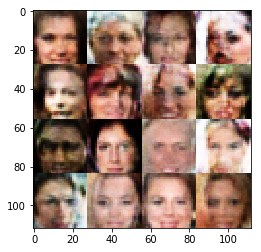

Epoch:1, Step:4300, Discriminator Loss:0.8962360620498657, Generator Loss:1.036881446838379
Epoch:1, Step:4310, Discriminator Loss:0.6932611465454102, Generator Loss:1.529146671295166
Epoch:1, Step:4320, Discriminator Loss:0.8275364637374878, Generator Loss:1.167830467224121
Epoch:1, Step:4330, Discriminator Loss:0.8038163781166077, Generator Loss:2.1257190704345703
Epoch:1, Step:4340, Discriminator Loss:0.9226517081260681, Generator Loss:1.0004279613494873
Epoch:1, Step:4350, Discriminator Loss:0.9328542947769165, Generator Loss:0.9618390798568726
Epoch:1, Step:4360, Discriminator Loss:1.05613374710083, Generator Loss:0.7712056636810303
Epoch:1, Step:4370, Discriminator Loss:0.796053946018219, Generator Loss:1.4120949506759644
Epoch:1, Step:4380, Discriminator Loss:0.9960108995437622, Generator Loss:1.0231361389160156
Epoch:1, Step:4390, Discriminator Loss:0.8880655765533447, Generator Loss:1.0454565286636353


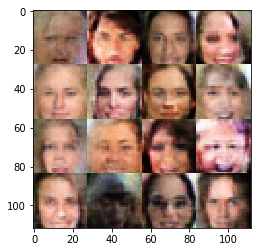

Epoch:1, Step:4400, Discriminator Loss:0.9369947910308838, Generator Loss:2.328157424926758
Epoch:1, Step:4410, Discriminator Loss:0.6282333135604858, Generator Loss:1.9361369609832764
Epoch:1, Step:4420, Discriminator Loss:1.2144498825073242, Generator Loss:0.6372013092041016
Epoch:1, Step:4430, Discriminator Loss:1.6254241466522217, Generator Loss:0.34575918316841125
Epoch:1, Step:4440, Discriminator Loss:0.5093019008636475, Generator Loss:2.1490893363952637
Epoch:1, Step:4450, Discriminator Loss:1.0501983165740967, Generator Loss:0.9638651609420776
Epoch:1, Step:4460, Discriminator Loss:0.8686505556106567, Generator Loss:1.323080062866211
Epoch:1, Step:4470, Discriminator Loss:0.9854468107223511, Generator Loss:0.8435516357421875
Epoch:1, Step:4480, Discriminator Loss:0.7272008657455444, Generator Loss:1.4952999353408813
Epoch:1, Step:4490, Discriminator Loss:1.0018424987792969, Generator Loss:0.8116458654403687


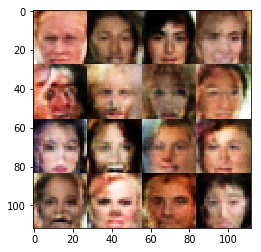

Epoch:1, Step:4500, Discriminator Loss:0.8107678890228271, Generator Loss:1.2027370929718018
Epoch:1, Step:4510, Discriminator Loss:0.5510377883911133, Generator Loss:2.006253242492676
Epoch:1, Step:4520, Discriminator Loss:0.8494795560836792, Generator Loss:1.6474473476409912
Epoch:1, Step:4530, Discriminator Loss:1.2118875980377197, Generator Loss:0.5922275185585022
Epoch:1, Step:4540, Discriminator Loss:0.7232609987258911, Generator Loss:1.4327735900878906
Epoch:1, Step:4550, Discriminator Loss:0.843226432800293, Generator Loss:1.7663373947143555
Epoch:1, Step:4560, Discriminator Loss:0.7961961030960083, Generator Loss:2.2031760215759277
Epoch:1, Step:4570, Discriminator Loss:0.8497503399848938, Generator Loss:1.1703565120697021
Epoch:1, Step:4580, Discriminator Loss:0.7186062335968018, Generator Loss:1.3110840320587158
Epoch:1, Step:4590, Discriminator Loss:0.8341726064682007, Generator Loss:1.182547926902771


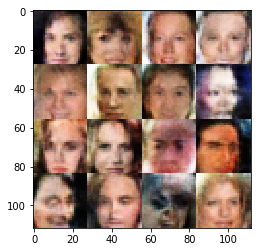

Epoch:1, Step:4600, Discriminator Loss:1.1192129850387573, Generator Loss:0.9182102680206299
Epoch:1, Step:4610, Discriminator Loss:0.604262113571167, Generator Loss:1.8260776996612549
Epoch:1, Step:4620, Discriminator Loss:0.6703670024871826, Generator Loss:1.4214537143707275
Epoch:1, Step:4630, Discriminator Loss:0.6856197118759155, Generator Loss:1.3818668127059937
Epoch:1, Step:4640, Discriminator Loss:0.7526435852050781, Generator Loss:1.2558376789093018
Epoch:1, Step:4650, Discriminator Loss:0.7273893356323242, Generator Loss:1.2287240028381348
Epoch:1, Step:4660, Discriminator Loss:1.254052996635437, Generator Loss:0.5861566662788391
Epoch:1, Step:4670, Discriminator Loss:0.7380678653717041, Generator Loss:2.7173244953155518
Epoch:1, Step:4680, Discriminator Loss:1.2545807361602783, Generator Loss:0.5721834897994995
Epoch:1, Step:4690, Discriminator Loss:1.5519254207611084, Generator Loss:0.4250812232494354


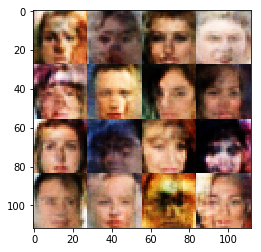

Epoch:1, Step:4700, Discriminator Loss:0.841825008392334, Generator Loss:1.1009262800216675
Epoch:1, Step:4710, Discriminator Loss:1.2795391082763672, Generator Loss:0.5401583909988403
Epoch:1, Step:4720, Discriminator Loss:1.1074650287628174, Generator Loss:0.7285895943641663
Epoch:1, Step:4730, Discriminator Loss:0.931979775428772, Generator Loss:1.4477158784866333
Epoch:1, Step:4740, Discriminator Loss:0.7713495492935181, Generator Loss:1.7129260301589966
Epoch:1, Step:4750, Discriminator Loss:0.8201130628585815, Generator Loss:1.0882534980773926
Epoch:1, Step:4760, Discriminator Loss:0.7840204238891602, Generator Loss:3.275573253631592
Epoch:1, Step:4770, Discriminator Loss:1.592470407485962, Generator Loss:0.36651474237442017
Epoch:1, Step:4780, Discriminator Loss:1.0910556316375732, Generator Loss:0.7061725854873657
Epoch:1, Step:4790, Discriminator Loss:0.8547187447547913, Generator Loss:1.507032036781311


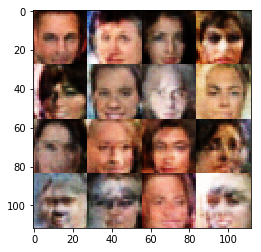

Epoch:1, Step:4800, Discriminator Loss:1.0209832191467285, Generator Loss:0.801459550857544
Epoch:1, Step:4810, Discriminator Loss:0.5908876657485962, Generator Loss:1.973458170890808
Epoch:1, Step:4820, Discriminator Loss:0.7878915071487427, Generator Loss:1.172949194908142
Epoch:1, Step:4830, Discriminator Loss:0.6604979038238525, Generator Loss:1.5437430143356323
Epoch:1, Step:4840, Discriminator Loss:1.1106486320495605, Generator Loss:0.722303032875061
Epoch:1, Step:4850, Discriminator Loss:0.9252493381500244, Generator Loss:0.9445996284484863
Epoch:1, Step:4860, Discriminator Loss:1.443145990371704, Generator Loss:0.43752411007881165
Epoch:1, Step:4870, Discriminator Loss:0.8391672968864441, Generator Loss:1.0850110054016113
Epoch:1, Step:4880, Discriminator Loss:1.1791255474090576, Generator Loss:1.8443880081176758
Epoch:1, Step:4890, Discriminator Loss:0.835606575012207, Generator Loss:1.0212419033050537


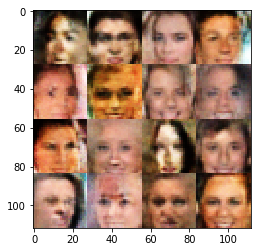

Epoch:1, Step:4900, Discriminator Loss:0.6625165939331055, Generator Loss:1.8883637189865112
Epoch:1, Step:4910, Discriminator Loss:0.6837502717971802, Generator Loss:1.5373951196670532
Epoch:1, Step:4920, Discriminator Loss:0.7975965142250061, Generator Loss:1.582624912261963
Epoch:1, Step:4930, Discriminator Loss:0.6871483325958252, Generator Loss:1.8899595737457275
Epoch:1, Step:4940, Discriminator Loss:1.0427827835083008, Generator Loss:0.7707799673080444
Epoch:1, Step:4950, Discriminator Loss:0.7054905891418457, Generator Loss:1.5900572538375854
Epoch:1, Step:4960, Discriminator Loss:1.2676424980163574, Generator Loss:0.5610033273696899
Epoch:1, Step:4970, Discriminator Loss:0.6924721002578735, Generator Loss:1.5147137641906738
Epoch:1, Step:4980, Discriminator Loss:0.6424177885055542, Generator Loss:1.4483146667480469
Epoch:1, Step:4990, Discriminator Loss:0.5189816951751709, Generator Loss:2.841478109359741


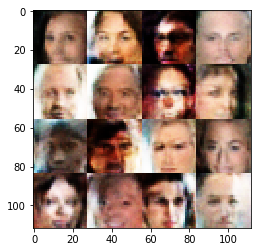

Epoch:1, Step:5000, Discriminator Loss:0.9954444169998169, Generator Loss:0.9132578372955322
Epoch:1, Step:5010, Discriminator Loss:0.5946627855300903, Generator Loss:3.0578808784484863
Epoch:1, Step:5020, Discriminator Loss:0.9677023887634277, Generator Loss:0.9476885795593262
Epoch:1, Step:5030, Discriminator Loss:1.0498459339141846, Generator Loss:2.8280787467956543
Epoch:1, Step:5040, Discriminator Loss:0.6154994964599609, Generator Loss:1.610236406326294
Epoch:1, Step:5050, Discriminator Loss:1.055760383605957, Generator Loss:3.8372321128845215
Epoch:1, Step:5060, Discriminator Loss:0.5750641822814941, Generator Loss:1.8622294664382935
Epoch:1, Step:5070, Discriminator Loss:0.700410008430481, Generator Loss:1.8159003257751465
Epoch:1, Step:5080, Discriminator Loss:1.4796898365020752, Generator Loss:0.44335609674453735
Epoch:1, Step:5090, Discriminator Loss:0.767810583114624, Generator Loss:1.2082453966140747


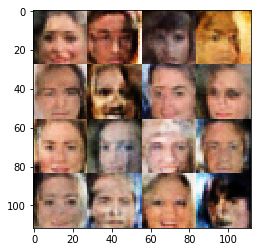

Epoch:1, Step:5100, Discriminator Loss:0.7433225512504578, Generator Loss:1.2690273523330688
Epoch:1, Step:5110, Discriminator Loss:0.8385424017906189, Generator Loss:1.9829580783843994
Epoch:1, Step:5120, Discriminator Loss:0.5630285143852234, Generator Loss:1.9528377056121826
Epoch:1, Step:5130, Discriminator Loss:0.6964258551597595, Generator Loss:1.3608568906784058
Epoch:1, Step:5140, Discriminator Loss:1.2724965810775757, Generator Loss:0.6143293380737305
Epoch:1, Step:5150, Discriminator Loss:0.6957793235778809, Generator Loss:1.3245539665222168
Epoch:1, Step:5160, Discriminator Loss:0.7191815376281738, Generator Loss:1.300338864326477
Epoch:1, Step:5170, Discriminator Loss:1.578127145767212, Generator Loss:0.38441386818885803
Epoch:1, Step:5180, Discriminator Loss:0.6045998334884644, Generator Loss:2.173694372177124
Epoch:1, Step:5190, Discriminator Loss:1.917454719543457, Generator Loss:0.25752246379852295


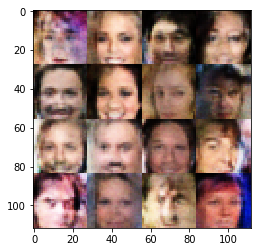

Epoch:1, Step:5200, Discriminator Loss:1.2540242671966553, Generator Loss:0.6061147451400757
Epoch:1, Step:5210, Discriminator Loss:0.6013891100883484, Generator Loss:1.975422978401184
Epoch:1, Step:5220, Discriminator Loss:0.6277012825012207, Generator Loss:1.7743815183639526
Epoch:1, Step:5230, Discriminator Loss:1.1810035705566406, Generator Loss:0.6267139315605164
Epoch:1, Step:5240, Discriminator Loss:0.7707257270812988, Generator Loss:1.5078214406967163
Epoch:1, Step:5250, Discriminator Loss:0.6924117803573608, Generator Loss:1.6349767446517944
Epoch:1, Step:5260, Discriminator Loss:0.7957305908203125, Generator Loss:1.1200456619262695
Epoch:1, Step:5270, Discriminator Loss:1.1843557357788086, Generator Loss:0.6342273950576782
Epoch:1, Step:5280, Discriminator Loss:0.4564797282218933, Generator Loss:2.7211198806762695
Epoch:1, Step:5290, Discriminator Loss:0.7134854793548584, Generator Loss:1.3603477478027344


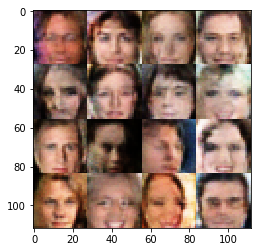

Epoch:1, Step:5300, Discriminator Loss:0.40996843576431274, Generator Loss:2.9542324542999268
Epoch:1, Step:5310, Discriminator Loss:0.6000741720199585, Generator Loss:1.8904407024383545
Epoch:1, Step:5320, Discriminator Loss:0.6911178827285767, Generator Loss:1.413006067276001
Epoch:1, Step:5330, Discriminator Loss:0.5657131671905518, Generator Loss:2.0620803833007812
Epoch:1, Step:5340, Discriminator Loss:0.5840504765510559, Generator Loss:1.8267321586608887
Epoch:1, Step:5350, Discriminator Loss:1.1065046787261963, Generator Loss:0.6622710824012756
Epoch:1, Step:5360, Discriminator Loss:0.6251746416091919, Generator Loss:2.1000752449035645
Epoch:1, Step:5370, Discriminator Loss:1.470921277999878, Generator Loss:0.43730366230010986
Epoch:1, Step:5380, Discriminator Loss:0.6015098094940186, Generator Loss:2.1957650184631348
Epoch:1, Step:5390, Discriminator Loss:1.1997965574264526, Generator Loss:0.6574681997299194


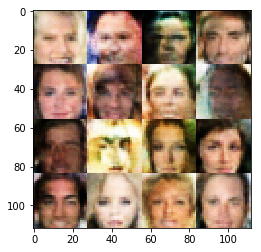

Epoch:1, Step:5400, Discriminator Loss:1.0151352882385254, Generator Loss:0.8779876828193665
Epoch:1, Step:5410, Discriminator Loss:0.8155803084373474, Generator Loss:1.3785760402679443
Epoch:1, Step:5420, Discriminator Loss:0.7535654306411743, Generator Loss:1.2819442749023438
Epoch:1, Step:5430, Discriminator Loss:1.3989897966384888, Generator Loss:0.4657745361328125
Epoch:1, Step:5440, Discriminator Loss:0.842004656791687, Generator Loss:1.1919364929199219
Epoch:1, Step:5450, Discriminator Loss:0.7353975772857666, Generator Loss:1.2787673473358154
Epoch:1, Step:5460, Discriminator Loss:0.8230365514755249, Generator Loss:1.4940530061721802
Epoch:1, Step:5470, Discriminator Loss:0.6157038807868958, Generator Loss:2.4581897258758545
Epoch:1, Step:5480, Discriminator Loss:0.9334232807159424, Generator Loss:1.9627938270568848
Epoch:1, Step:5490, Discriminator Loss:1.3686881065368652, Generator Loss:0.4927113950252533


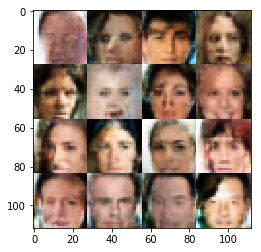

Epoch:1, Step:5500, Discriminator Loss:0.8846549987792969, Generator Loss:1.096631407737732
Epoch:1, Step:5510, Discriminator Loss:0.714248776435852, Generator Loss:1.2885754108428955
Epoch:1, Step:5520, Discriminator Loss:0.6833066940307617, Generator Loss:1.3519861698150635
Epoch:1, Step:5530, Discriminator Loss:0.46959900856018066, Generator Loss:2.4428205490112305
Epoch:1, Step:5540, Discriminator Loss:1.137831687927246, Generator Loss:0.6930699348449707
Epoch:1, Step:5550, Discriminator Loss:0.6501278877258301, Generator Loss:1.4955312013626099
Epoch:1, Step:5560, Discriminator Loss:0.8156929016113281, Generator Loss:1.0951848030090332
Epoch:1, Step:5570, Discriminator Loss:0.6388329267501831, Generator Loss:1.9706759452819824
Epoch:1, Step:5580, Discriminator Loss:1.1198320388793945, Generator Loss:0.6954442858695984
Epoch:1, Step:5590, Discriminator Loss:1.6619731187820435, Generator Loss:0.36314594745635986


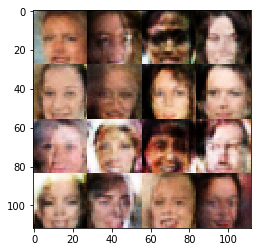

Epoch:1, Step:5600, Discriminator Loss:0.7898550033569336, Generator Loss:2.355431079864502
Epoch:1, Step:5610, Discriminator Loss:0.8716067671775818, Generator Loss:0.9924364686012268
Epoch:1, Step:5620, Discriminator Loss:0.4655084013938904, Generator Loss:3.0781021118164062
Epoch:1, Step:5630, Discriminator Loss:0.4580596387386322, Generator Loss:2.4876902103424072
Epoch:1, Step:5640, Discriminator Loss:0.4702794551849365, Generator Loss:2.280010223388672
Epoch:1, Step:5650, Discriminator Loss:1.067148208618164, Generator Loss:0.7063218951225281
Epoch:1, Step:5660, Discriminator Loss:0.6164050698280334, Generator Loss:2.151033401489258
Epoch:1, Step:5670, Discriminator Loss:1.1083885431289673, Generator Loss:0.6714881658554077
Epoch:1, Step:5680, Discriminator Loss:0.6333696246147156, Generator Loss:1.588670253753662
Epoch:1, Step:5690, Discriminator Loss:0.8214173316955566, Generator Loss:1.0444313287734985


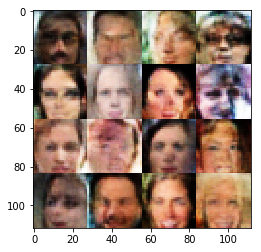

Epoch:1, Step:5700, Discriminator Loss:2.2957844734191895, Generator Loss:0.1730414479970932
Epoch:1, Step:5710, Discriminator Loss:0.6913310885429382, Generator Loss:1.3952066898345947
Epoch:1, Step:5720, Discriminator Loss:0.5273281931877136, Generator Loss:4.628467559814453
Epoch:1, Step:5730, Discriminator Loss:0.5650069117546082, Generator Loss:3.044252634048462
Epoch:1, Step:5740, Discriminator Loss:0.7728150486946106, Generator Loss:1.1226036548614502
Epoch:1, Step:5750, Discriminator Loss:0.5569501519203186, Generator Loss:1.893132209777832
Epoch:1, Step:5760, Discriminator Loss:0.7355101704597473, Generator Loss:1.3365302085876465
Epoch:1, Step:5770, Discriminator Loss:0.6946021914482117, Generator Loss:1.6271511316299438
Epoch:1, Step:5780, Discriminator Loss:0.6066747903823853, Generator Loss:1.8693474531173706
Epoch:1, Step:5790, Discriminator Loss:0.9514280557632446, Generator Loss:0.858938992023468


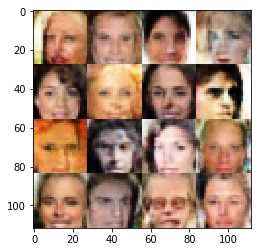

Epoch:1, Step:5800, Discriminator Loss:1.512296438217163, Generator Loss:0.43566814064979553
Epoch:1, Step:5810, Discriminator Loss:0.48456814885139465, Generator Loss:2.178187847137451
Epoch:1, Step:5820, Discriminator Loss:1.2143323421478271, Generator Loss:0.6156387329101562
Epoch:1, Step:5830, Discriminator Loss:0.7850967049598694, Generator Loss:3.780993938446045
Epoch:1, Step:5840, Discriminator Loss:0.5616266131401062, Generator Loss:1.8266541957855225
Epoch:1, Step:5850, Discriminator Loss:1.0496653318405151, Generator Loss:0.7543383240699768
Epoch:1, Step:5860, Discriminator Loss:0.5533332824707031, Generator Loss:2.2197647094726562
Epoch:1, Step:5870, Discriminator Loss:0.6055178046226501, Generator Loss:1.6754035949707031
Epoch:1, Step:5880, Discriminator Loss:1.1539885997772217, Generator Loss:0.6593998670578003
Epoch:1, Step:5890, Discriminator Loss:0.5077177286148071, Generator Loss:3.185595750808716


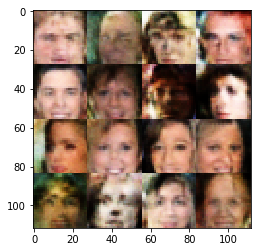

Epoch:1, Step:5900, Discriminator Loss:0.7186702489852905, Generator Loss:1.3199481964111328
Epoch:1, Step:5910, Discriminator Loss:0.6062847375869751, Generator Loss:1.609195351600647
Epoch:1, Step:5920, Discriminator Loss:0.8513956069946289, Generator Loss:1.935425043106079
Epoch:1, Step:5930, Discriminator Loss:1.4075446128845215, Generator Loss:0.46868717670440674
Epoch:1, Step:5940, Discriminator Loss:0.6877858638763428, Generator Loss:1.4640560150146484
Epoch:1, Step:5950, Discriminator Loss:0.4454032778739929, Generator Loss:2.6563072204589844
Epoch:1, Step:5960, Discriminator Loss:0.6567564010620117, Generator Loss:1.387982964515686
Epoch:1, Step:5970, Discriminator Loss:0.6695041656494141, Generator Loss:1.3817517757415771
Epoch:1, Step:5980, Discriminator Loss:0.5322716236114502, Generator Loss:3.4346868991851807
Epoch:1, Step:5990, Discriminator Loss:0.45322540402412415, Generator Loss:3.0962705612182617


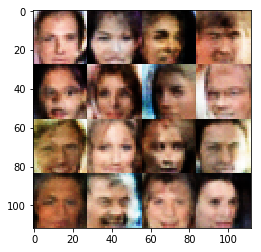

Epoch:1, Step:6000, Discriminator Loss:0.8768133521080017, Generator Loss:2.873751640319824
Epoch:1, Step:6010, Discriminator Loss:1.030461311340332, Generator Loss:0.7513260245323181
Epoch:1, Step:6020, Discriminator Loss:0.7693672180175781, Generator Loss:1.1202452182769775
Epoch:1, Step:6030, Discriminator Loss:1.9555249214172363, Generator Loss:0.241832435131073
Epoch:1, Step:6040, Discriminator Loss:0.5744884014129639, Generator Loss:2.2558884620666504
Epoch:1, Step:6050, Discriminator Loss:0.6399840116500854, Generator Loss:1.4403338432312012
Epoch:1, Step:6060, Discriminator Loss:1.0190300941467285, Generator Loss:0.7617655396461487
Epoch:1, Step:6070, Discriminator Loss:0.47949790954589844, Generator Loss:2.192747116088867
Epoch:1, Step:6080, Discriminator Loss:0.8894031643867493, Generator Loss:2.581787586212158
Epoch:1, Step:6090, Discriminator Loss:0.5451062321662903, Generator Loss:2.329460620880127


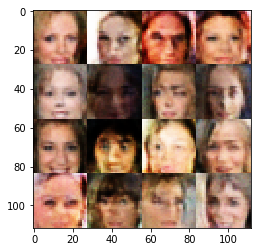

Epoch:1, Step:6100, Discriminator Loss:1.1699362993240356, Generator Loss:0.6437278985977173
Epoch:1, Step:6110, Discriminator Loss:0.5307004451751709, Generator Loss:1.9549205303192139
Epoch:1, Step:6120, Discriminator Loss:0.4082474410533905, Generator Loss:2.904369831085205
Epoch:1, Step:6130, Discriminator Loss:2.035613536834717, Generator Loss:0.22698356211185455
Epoch:1, Step:6140, Discriminator Loss:1.3064937591552734, Generator Loss:0.535425066947937
Epoch:1, Step:6150, Discriminator Loss:0.9003108143806458, Generator Loss:0.9737816452980042
Epoch:1, Step:6160, Discriminator Loss:0.5120636820793152, Generator Loss:2.427370071411133
Epoch:1, Step:6170, Discriminator Loss:0.49103260040283203, Generator Loss:2.0555644035339355
Epoch:1, Step:6180, Discriminator Loss:0.5123671889305115, Generator Loss:2.0869336128234863
Epoch:1, Step:6190, Discriminator Loss:2.2874436378479004, Generator Loss:0.17932885885238647


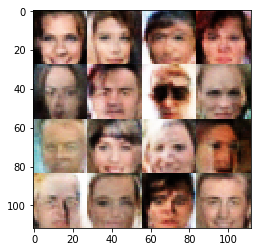

Epoch:1, Step:6200, Discriminator Loss:0.4641454815864563, Generator Loss:2.4866397380828857
Epoch:1, Step:6210, Discriminator Loss:0.5786751508712769, Generator Loss:2.24519681930542
Epoch:1, Step:6220, Discriminator Loss:0.7000279426574707, Generator Loss:1.3056402206420898
Epoch:1, Step:6230, Discriminator Loss:0.6025184392929077, Generator Loss:1.6183428764343262
Epoch:1, Step:6240, Discriminator Loss:0.5674302577972412, Generator Loss:1.8111478090286255
Epoch:1, Step:6250, Discriminator Loss:0.6201057434082031, Generator Loss:2.048915386199951
Epoch:1, Step:6260, Discriminator Loss:0.6206861138343811, Generator Loss:2.274512529373169
Epoch:1, Step:6270, Discriminator Loss:0.5530306696891785, Generator Loss:1.7871904373168945
Epoch:1, Step:6280, Discriminator Loss:0.37861907482147217, Generator Loss:3.50850248336792
Epoch:1, Step:6290, Discriminator Loss:0.4736385941505432, Generator Loss:2.6130871772766113


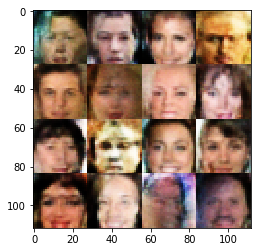

Epoch:1, Step:6300, Discriminator Loss:1.524837851524353, Generator Loss:0.4272775948047638
Epoch:1, Step:6310, Discriminator Loss:0.8355538249015808, Generator Loss:2.229757785797119
Epoch:1, Step:6320, Discriminator Loss:0.6470188498497009, Generator Loss:1.4449135065078735
Epoch:1, Step:6330, Discriminator Loss:0.8442071676254272, Generator Loss:1.1147910356521606


In [48]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.